# **Travel Insurance Claim Prediction**
#### Created by [Adrian Irshad](https://github.com/adrianirshad)

## **1. Business Understanding**

**Context**

A travel insurance company wants to build a machine learning model to predict whether a customer will file an insurance claim after purchasing a travel policy. The company collects various information during the policy registration process, including details about the sales agency, distribution channel, insurance product, travel destination, customer demographics, trip duration, and financial data related to the policy. By identifying customers likely to make claims, the company aims to optimize risk assessment, pricing strategies, fraud detection, and customer service operations.

**Target**

- **0** : No claim made  
- **1** : Claim made

**Problem Statement**

The travel insurance company faces challenges in identifying customers who are likely to file a claim after purchasing a policy. Without accurate predictions, resources and efforts may be wasted on claims management for customers who are unlikely to make any claims, leading to inefficiencies in risk assessment and customer service.

The company wants to improve its claims management and customer service operations by predicting the likelihood of a customer filing a claim based on various demographic, financial, and trip-related features. Accurate predictions will help the company optimize its resources and enhance customer experience.

**Goals**

- The company aims to predict the likelihood of a customer filing an insurance claim, allowing them to better allocate resources and manage risk.
- The company also wants to understand the factors that influence whether a customer will file a claim, so they can adjust their policies, pricing strategies, and customer support processes accordingly.

**Analytic Approach**

The approach will involve analyzing the data to uncover patterns that distinguish customers who are likely to file claims from those who are not.

We will build a classification model that predicts whether a customer will file a claim based on their demographics, trip details, and financial data related to the policy.


**Metric Evaluation**

<img src='ConfusionMatrixFPFN.PNG' width='35%'>

**Type 1 Error** : **False Positive**
* Consequence : Wasted resources on claims management for customers who do not file a claim, leading to unnecessary costs, time, and effort spent on handling low-risk customers.

**Type 2 Error** : **False Negative** 
* Consequence : Missed opportunities for handling claims from customers who do file a claim, which could lead to dissatisfied customers and missed opportunities to improve customer satisfaction and business performance.

Based on the consequences, the goal is to build a model that minimizes the company's operational costs while avoiding missing any potential claims. We want to accurately identify customers likely to file a claim, but also avoid misclassifying those unlikely to file claims as high-risk customers.

Thus, we will focus on maximizing correct positive predictions (true positives) while keeping false positives (incorrectly classifying low-risk customers as high-risk) to a minimum. 

The main metric we will use is ROC AUC (Receiver Operating Characteristic Area Under Curve), as it balances the trade-off between true positive rate and false positive rate, helping us to choose a threshold that best suits our goal of minimizing wasted resources and capturing as many potential claims as possible.


---

## **Libraries**

In [356]:
# Data handling and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import missingno as msno
from IPython.display import display, HTML
import pickle

# Warning configuration
import warnings
warnings.filterwarnings('ignore')

# Set display options for pandas
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder,
    RobustScaler,
    StandardScaler,
    KBinsDiscretizer
)

# Enable experimental features
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Feature analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Models - Classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

# Evaluation metrics
from sklearn.metrics import (
    precision_recall_curve,
    precision_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    auc,
    make_scorer,
    recall_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

# Model validation and tuning
from sklearn.model_selection import (
    cross_val_score,
    cross_val_predict,
    StratifiedKFold,
    cross_validate,
    GridSearchCV,
    RandomizedSearchCV
)

## **2. Data Understanding**

Source : [Travel Insurance Data](https://drive.google.com/drive/u/0/folders/1sRZ5xnpsiMID6RFAVPkQN4RLyivdnLAG)

### Feature Descriptions

| **Feature**             | **Description**                                  |
|--------------------|----------------------------------------------|
| **Agency** | Name of agency.                            |
| **Agency Type** | Type of travel insurance agencies.           |
| **Distribution Channel** | Channel of travel insurance agencies.        |
| **Product Name** | Name of the travel insurance products.     |
| **Gender** | Gender of insured.                           |
| **Duration** | Duration of travel.                          |
| **Destination** | Destination of travel.                       |
| **Net Sales** | Amount of sales of travel insurance policies. |
| **Commission (in value)** | Commission received for travel insurance agency. |
| **Age** | Age of insured.                              |
| **Claim** | Claim status.                                |

In [357]:
df = pd.read_csv('data_travel_insurance.csv')
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


In [358]:
print(f'There are {df.shape[0]} observations and {df.shape[1]} features in the dataset.')

There are 44328 observations and 11 features in the dataset.


In [359]:
listItem = []
for col in df.columns :
    listItem.append([col,
                     df[col].dtype,
                     df[col].isna().sum(),
                     round((df[col].isna().sum()/len(df[col])) * 100,2),
                     df[col].nunique(), list(df[col].drop_duplicates().head(3).values)]); 

dfDesc = pd.DataFrame(columns=['Feature', 'Data Type', 'Missing Values', 'Percentage of Missing Values', 'Number of Unique Values', 'Sample'],
                      data=listItem)
dfDesc

,Feature,Data Type,Missing Values,Percentage of Missing Values,Number of Unique Values,Sample
0,Agency,object,0,0.00,16,"[C2B, EPX, JZI]"
1,Agency Type,object,0,0.00,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,0,0.00,2,"[Online, Offline]"
3,Product Name,object,0,0.00,26,"[Annual Silver Plan, Cancellation Plan, Basic Plan]"
4,Gender,object,31647,71.39,2,"[F, nan, M]"
5,Duration,int64,0,0.00,437,"[365, 4, 19]"
6,Destination,object,0,0.00,138,"[SINGAPORE, MALAYSIA, INDIA]"
7,Net Sales,float64,0,0.00,1006,"[216.0, 10.0, 22.0]"
8,Commision (in value),float64,0,0.00,915,"[54.0, 0.0, 7.7]"
9,Age,int64,0,0.00,89,"[57, 33, 26]"


The `Gender` column contains 31,647 missing values, accounting for approximately 71.39% of the total records. This represents a substantial proportion of missing data, which significantly limits its reliability and usefulness in modeling or analysis. Imputing such a large volume of missing entries could introduce bias or noise, and retaining this feature may not contribute meaningful insights. Therefore, to maintain data quality and avoid potential distortion in our analysis or predictive modeling, the `Gender` column will be excluded from further analysis.

In [360]:
print(f'There are {df.duplicated().sum()} duplicates in the dataset, accounting for approximately {round((df.duplicated().sum()/len(df)) * 100,2)}% of the dataset.')

There are 4667 duplicates in the dataset, accounting for approximately 10.53% of the dataset.


Although approximately 10% of the data appears to be duplicated, the dataset does not include any unique customer identifiers, making it difficult to determine whether these records are true duplicates or simply reflect customers with similar characteristics (e.g., age, gender, destination).

In [361]:
display(round(df.describe(include=np.number).drop('count', axis=0), 1),
        df.describe(include=object).T.drop(['count', 'unique'], axis=1))

,Duration,Net Sales,Commision (in value),Age
mean,49.4,40.6,9.7,39.9
std,109.2,48.7,19.6,14.0
min,-1.0,-357.5,0.0,0.0
25%,9.0,18.0,0.0,35.0
50%,22.0,26.5,0.0,36.0
75%,53.0,48.0,11.6,43.0
max,4881.0,810.0,283.5,118.0


,top,freq
Agency,EPX,24656
Agency Type,Travel Agency,32113
Distribution Channel,Online,43572
Product Name,Cancellation Plan,12979
Gender,M,6504
Destination,SINGAPORE,9267
Claim,No,43651


Numerical Features:

- Duration
- Net Sales
- Commision (in Value)
- Age

Categorical Features :

- Agency
- Agency Type
- Distribution Channel
- Product Name
- Gender
- Destination

## **3. Data Cleaning**

### Missing Values

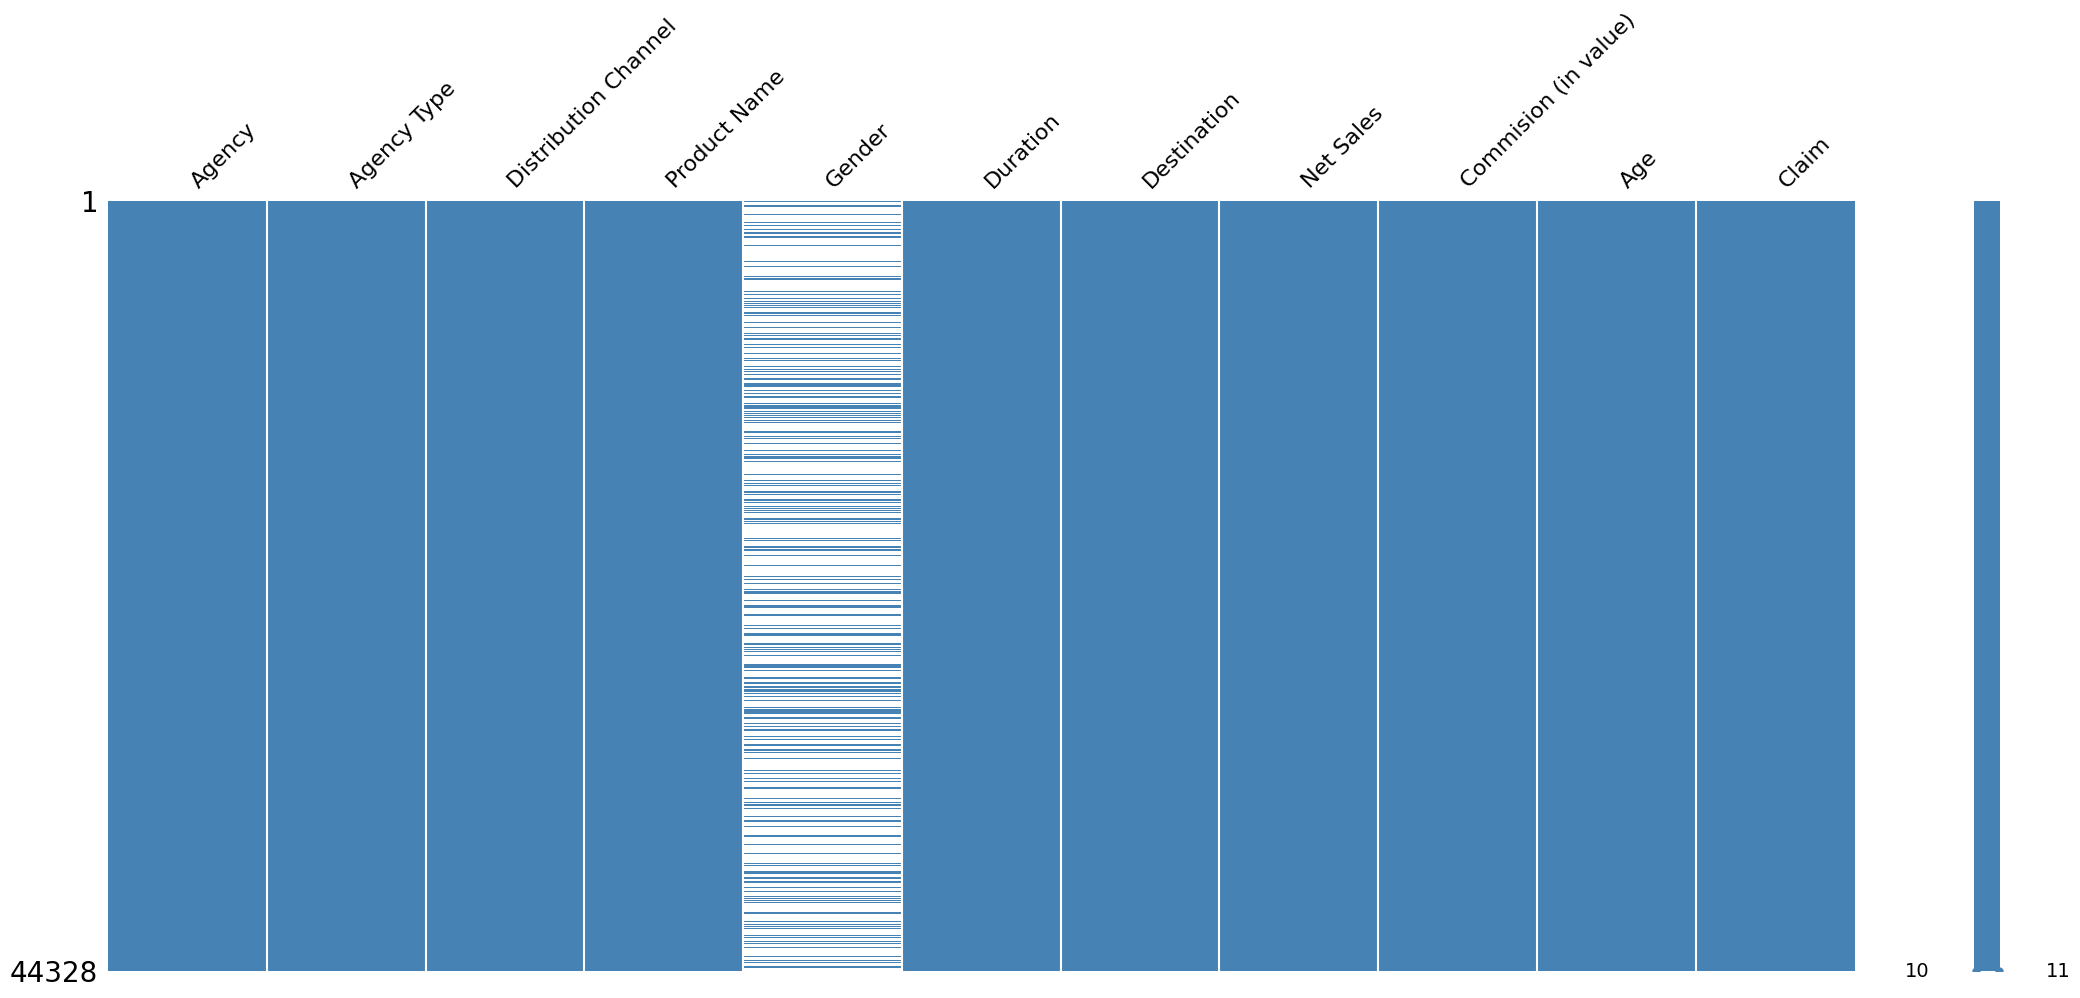

In [362]:
msno.matrix(df, color=to_rgb('steelblue')); 

* **Missingness Matrix Analysis (msno.matrix) :** This visualization shows missing data (white lines) across variables.

    * **Observed Missingness :**
        * Most columns, including **`Product Name`**, are largely complete (solid blue), indicating no missing values.
        * The **`Gender`** column, however, exhibits substantial missing data (many white lines).

    * **Likely Missing Data Mechanism for `Gender` :**
        * The scattered, seemingly random pattern of missingness in the `Gender` column suggests the data is **Missing Completely At Random (MCAR)**. This implies the missingness is likely due to random factors, not related to other observed data or the missing `Gender` value itself.
        * **Missing At Random (MAR)** is also possible if the missingness depends on other *observed* variables (e.g., `Gender` is more often missing for entries from a specific `Agency Type`), which this plot alone can't fully confirm.
        * **Missing Not At Random (MNAR)** is unlikely, as there are no visual patterns indicating missingness in `Gender` is tied to the actual `Gender` value.

* **Key Takeaway :** **`Gender` is the primary column with missing values.** The visual pattern strongly leans towards **MCAR** for `Gender`, simplifying the initial approach to handling its missing data. Further statistical tests are recommended for confirmation.

In [363]:
df.drop(['Gender'],axis=1, inplace=True)

### Duplicates

In [364]:
print(f'Number of duplictes : {df.duplicated().sum()} ({round(df.duplicated().sum()/len(df)*100,2)}%)')

Number of duplictes : 5004 (11.29%)


In [365]:
df.drop_duplicates(inplace=True)

There are 4667 (10.53%) duplicates within the datset. In order to reduce the chances of overfitting, we will be dropping the duplicates.

### Changing Data Types

In [366]:
df['Claim'] = df['Claim'].map({
    'No' : 0,
    'Yes' : 1
})

In [367]:
claim_counts = df['Claim'].value_counts()
claim_percentages = df['Claim'].value_counts(normalize=True)

df_claim = pd.DataFrame({
    'Count': claim_counts,
    'Percentage': (claim_percentages * 100).round(2)
})

df_claim

,Count,Percentage
Claim,,
0,38651,98.29
1,673,1.71


### Distribution of Features

#### Target Feature

- Claim

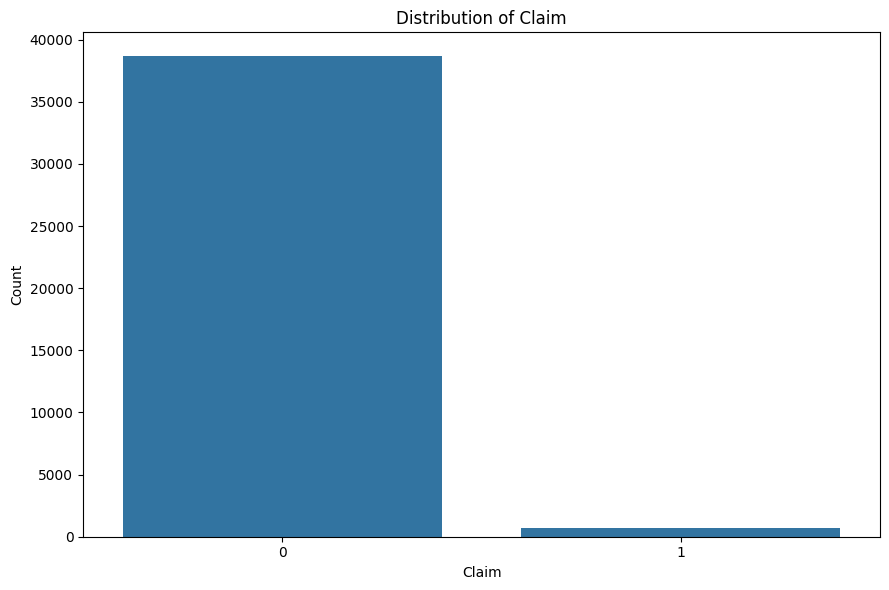

In [368]:
plt.figure(figsize=(9, 6))
sns.countplot(data=df, x='Claim')
plt.title('Distribution of Claim')
plt.xlabel('Claim')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### Numerical Features

- Duration
- Net Sales
- Commision (in Value)
- Age

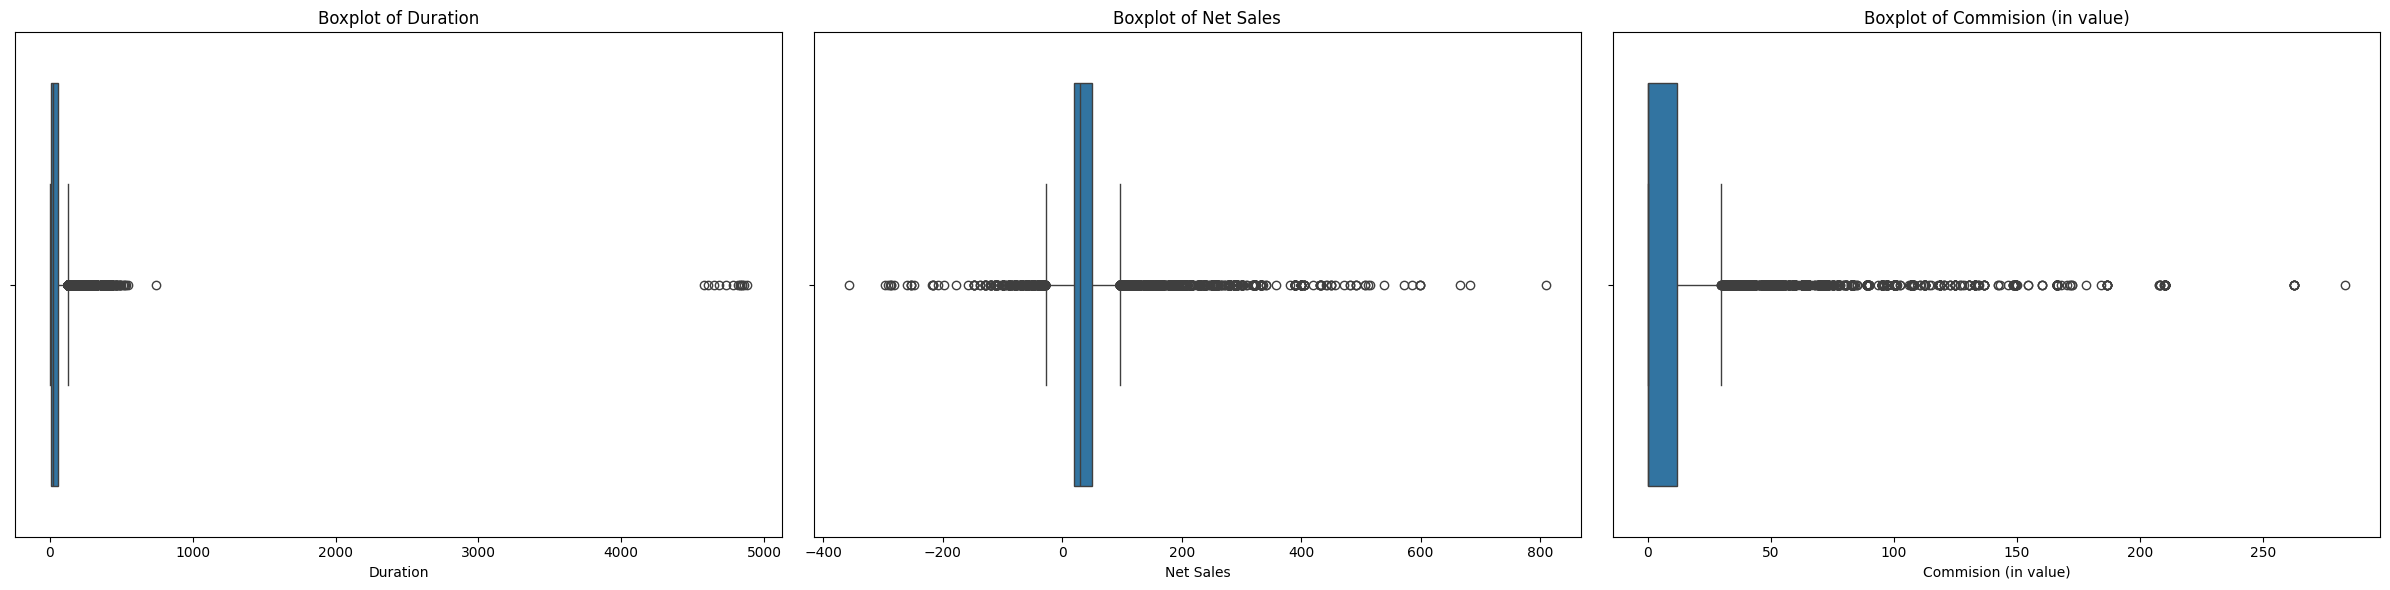

In [477]:
numerical_features = ['Duration', 'Net Sales', 'Commision (in value)']

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(data=df, x=feature, ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature}')
    axes[i].set_xlabel(feature)

plt.tight_layout()
plt.show()

* **Boxplot Analysis of Numerical Features :** These boxplots provide a summary of the distribution and potential outliers for `Duration`, `Net Sales`, and `Commission`. These plots offer a foundational understanding of data spread and central tendency, preceding more detailed density views like KDE and violin plots.

    * **`Duration` Boxplot :**
        * The majority of `Duration` values are highly concentrated at the lower end, indicated by a very narrow box close to zero.
        * A significant number of outliers are present, extending to durations well beyond 4000, suggesting some policies have exceptionally long durations.

    * **`Net Sales` Boxplot :**
        * The central box is tightly clustered around zero, indicating that most `Net Sales` values are near this point.
        * The plot shows a range of values, including negative ones, which likely represent returns or adjustments. Numerous outliers are visible on both the positive and negative sides.

    * **`Commission` Boxplot :**
        * Similar to `Net Sales`, the bulk of `Commission` values are very low, with the box tightly packed near zero.
        * Outliers extend significantly into higher commission values, indicating instances where commissions are considerably larger than the typical range.

* **Key Takeaway :** These boxplots highlight that `Duration`, `Net Sales`, and `Commission` are heavily right-skewed with many values concentrated at the lower end and a substantial number of positive outliers. `Net Sales` also shows negative values and outliers. This initial overview helps in understanding the scale and typical ranges of these variables before delving into more granular density analyses.

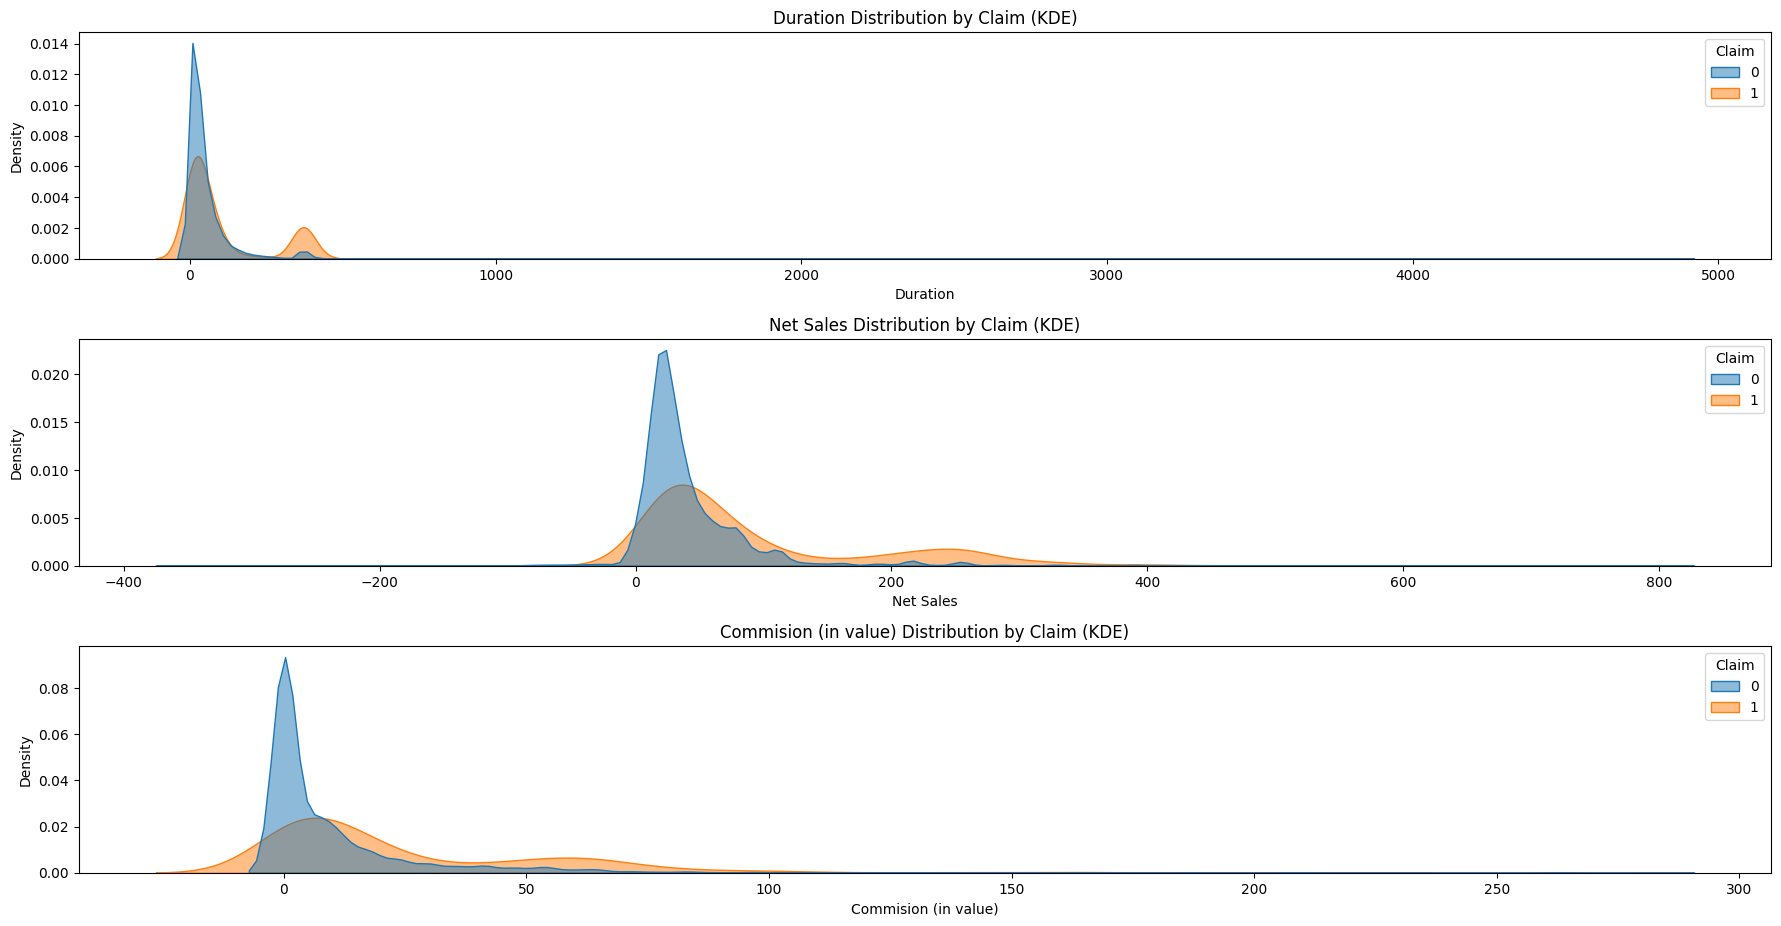

In [443]:
plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(4, 1, i)
    sns.kdeplot(data=df, x=col, hue='Claim', common_norm=False, fill=True, alpha=0.5)
    plt.title(f'{col} Distribution by Claim (KDE)')
    plt.xlabel(col)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

* **Distribution by Claim (KDE) for Numerical Features :** These Kernel Density Estimate (KDE) plots illustrate the probability density distribution for `Duration`, `Net Sales`, and `Commission` values, separated by whether a claim occurred ('1') or not ('0').

    * **`Duration` Distribution :**
        * Both claims and non-claims show a very strong peak at lower durations, indicating a high frequency of short-duration events.
        * The distribution for non-claims (blue) is more concentrated at shorter durations, while claims (orange) show a slightly broader spread, with a smaller, secondary peak around 500-1000 units. This suggests that longer durations might be marginally more associated with claims.

    * **`Net Sales` Distribution :**
        * Both claim and non-claim distributions are heavily skewed towards lower `Net Sales` values, with a significant peak near zero.
        * The non-claim distribution (blue) has a sharper, higher peak around zero, while the claim distribution (orange) is slightly flatter and extends further into positive `Net Sales` values. This hints that higher `Net Sales` values might be slightly more indicative of a claim.
        * There are also instances of negative `Net Sales`, particularly for non-claims, which might represent returns or adjustments.

    * **`Commission` Distribution :**
        * Similar to `Net Sales`, both distributions are concentrated at lower `Commission` values, peaking around zero.
        * The non-claim distribution (blue) has a more pronounced peak at lower commission values, while the claim distribution (orange) is again slightly broader and extends to higher commission values. This implies that higher commission amounts might be somewhat associated with claims.

* **Key Takeaway :** For all three numerical features, the distributions for claims and non-claims largely overlap, with a strong concentration at lower values. However, there's a subtle trend where claims tend to have a slightly wider spread and extend to moderately higher values in `Duration`, `Net Sales`, and `Commission` compared to non-claims. This suggests that while these features may not be strong individual discriminators, they might contribute to the model's ability to differentiate between claims and non-claims at the higher end of their respective ranges.

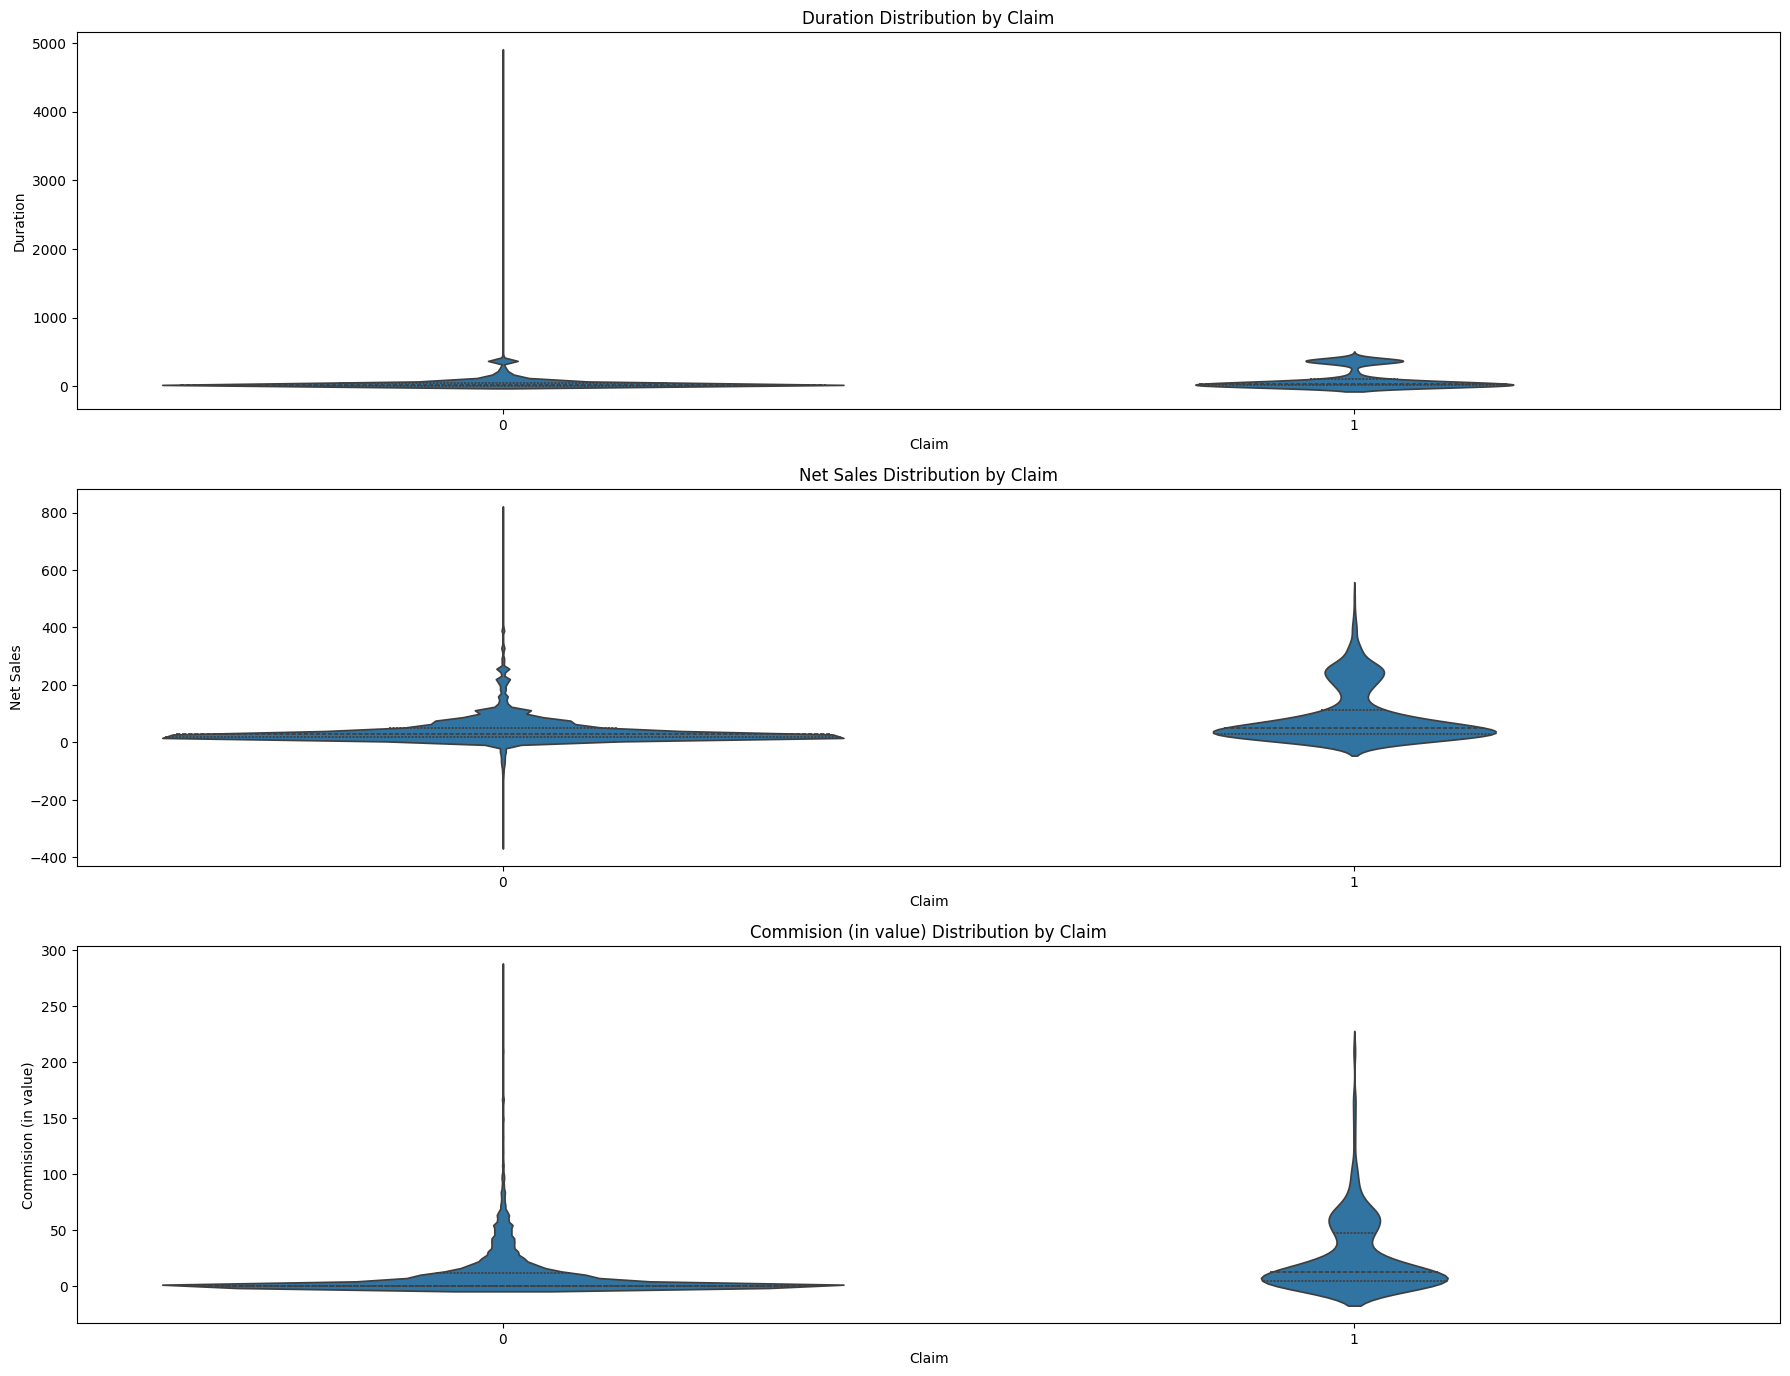

In [450]:
plt.figure(figsize=(18, 18))

for i, col in enumerate(numerical_features, 1):
    plt.subplot(4, 1, i)
    sns.violinplot(data=df, x='Claim', y=col, inner='quartile')
    plt.title(f'{col} Distribution by Claim')
    plt.xlabel('Claim')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

* **Violin Plot Distribution by Claim for Numerical Features :** These violin plots visually represent the distribution of `Duration`, `Net Sales`, and `Commission` for both non-claims (Claim '0') and claims (Claim '1'). The width of the violin indicates the density of data points at different values.

    * **`Duration` Distribution :**
        * **Claim '0' (Non-Claims) :** The distribution is highly concentrated at very low durations (near zero), with a very thin, tall body indicating a strong majority of non-claims have short durations. There are some outliers extending to very high durations, but these are sparse.
        * **Claim '1' (Claims) :** This distribution is also concentrated at lower durations but appears slightly more spread out, with a noticeable bulge around a few hundred units, suggesting that claims might occur across a slightly wider range of short to medium durations compared to non-claims.

    * **`Net Sales` Distribution :**
        * **Claim '0' (Non-Claims) :** Highly dense around zero, with a significant number of data points clustered there. The tails extend to both negative (returns/adjustments) and positive values, but the density quickly drops off.
        * **Claim '1' (Claims) :** Also concentrated around zero, but the violin shape appears slightly broader on the positive side compared to non-claims, indicating that claims might be associated with a slightly higher average or more varied `Net Sales` values.

    * **`Commission` Distribution :**
        * **Claim '0' (Non-Claims) :** Very dense around zero, with most non-claims having very low commission values.
        * **Claim '1' (Claims) :** The distribution for claims shows a notably wider spread towards higher commission values compared to non-claims, even though its peak is still at lower values. This suggests that while low commissions are common for claims, higher commission values are more frequently observed with claims than with non-claims.

* **Key Takeaway :** The violin plots reinforce insights from KDE plots, illustrating the heavy concentration of data points for both claims and non-claims at the lower end of `Duration`, `Net Sales`, and `Commission`. However, they more clearly visualize the subtle differences: claims show a slightly broader and sometimes higher distribution for these numerical features, suggesting that while the majority of values are low, claims tend to be associated with slightly elevated or more varied magnitudes in these financial and temporal aspects.

In [449]:
eda_stats = df.groupby('Claim')[numerical_features].describe().transpose()
print("\nDescriptive Statistics by Claim :\n")
print(eda_stats)


Descriptive Statistics by Claim :

Claim                                  0           1
Duration             count  38651.000000  673.000000
                     mean      51.335800  106.271917
                     std      112.661020  139.934037
                     min       -1.000000    2.000000
                     25%       11.000000   14.000000
                     50%       25.000000   35.000000
                     75%       56.000000  107.000000
                     max     4881.000000  431.000000
Net Sales            count  38651.000000  673.000000
                     mean      41.311696   93.363908
                     std       48.141063   92.751354
                     min     -357.500000    4.760000
                     25%       19.000000   29.000000
                     50%       28.000000   50.500000
                     75%       49.500000  112.000000
                     max      810.000000  507.000000
Commision (in value) count  38651.000000  673.000000
          

- **Customers who made claims had significantly longer trip durations**, with a median of 35 days versus 25 days for non-claimants, indicating that longer trips may carry increased risk.
- **Average net sales for claims were more than double** (93.36 vs. 41.31), suggesting that higher-value purchases are more likely to result in claims.
- **Commission values also showed a substantial difference**, with a median of 12.13 for claims compared to 0 for non-claims, possibly reflecting a link between product type and commission structure.
- **The upper quartile for duration and net sales among claims is notably higher**, pointing to a heavier-tailed distribution. For example, 75% of claimants spent over 112 compared to 49.5 for non-claimants.
- **Presence of negative values in duration and net sales** for non-claimants could indicate data quality issues that should be addressed before modeling or reporting.

#### Categorical Features

- Agency
- Agency Type
- Distribution Channel
- Product Name
- Gender
- Destination

##### `Agency`

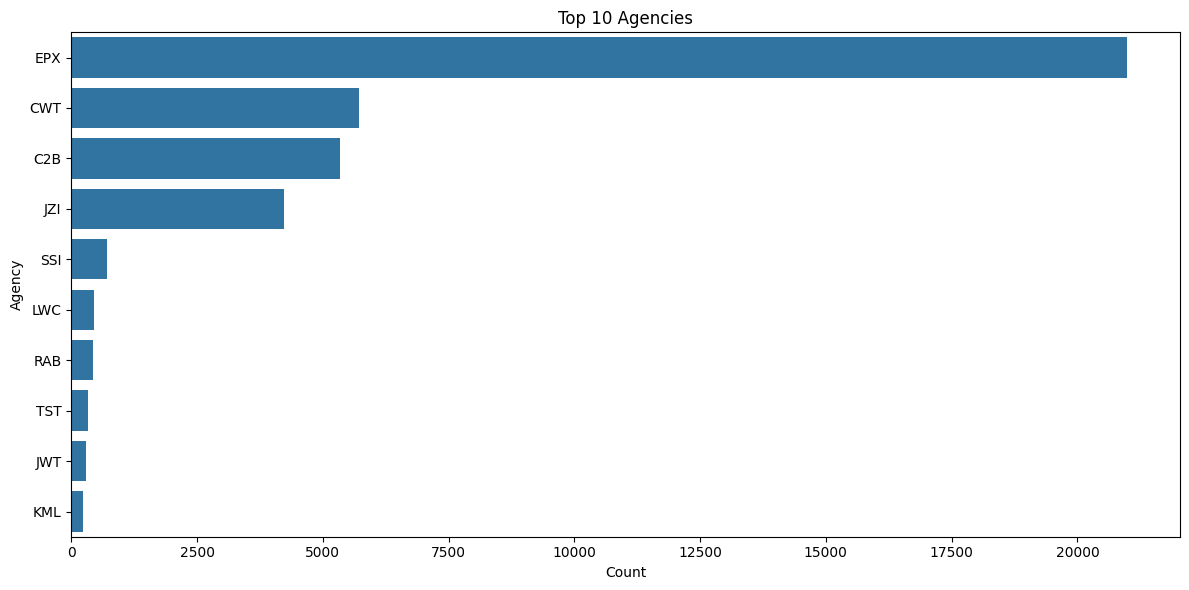

In [370]:
top_10_agencies = df['Agency'].value_counts().nlargest(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_agencies.values, y=top_10_agencies.index)
plt.title('Top 10 Agencies')
plt.xlabel('Count')
plt.ylabel('Agency')
plt.tight_layout()
plt.show()

In [371]:
agency_claim_distribution = (
    pd.crosstab(df['Agency'], df['Claim'], normalize='all') * 100
).round(3).sort_values(by=1, ascending=False)

agency_claim_distribution

Claim,0,1
Agency,,
C2B,12.539,1.025
EPX,53.039,0.338
CWT,14.398,0.163
LWC,1.076,0.074
JZI,10.708,0.056
KML,0.570,0.013
SSI,1.795,0.013
JWT,0.712,0.010
CCR,0.285,0.005


In [372]:
agency_distribution = pd.DataFrame({
    'Agency': df['Agency'].value_counts().index,
    'Count': df['Agency'].value_counts().values,
    'Percentage': (df['Agency'].value_counts(normalize=True) * 100).round(2).values
})

agency_distribution

,Agency,Count,Percentage
0,EPX,20990,53.38
1,CWT,5726,14.56
2,C2B,5334,13.56
3,JZI,4233,10.76
4,SSI,711,1.81
5,LWC,452,1.15
6,RAB,440,1.12
7,TST,329,0.84
8,JWT,284,0.72
9,KML,229,0.58


In [373]:
claim_rates_agency = (df.groupby('Agency')['Claim'].mean() * 100).round(2)
claim_rates_agency_df = claim_rates_agency.to_frame().rename(columns={'Claim': 'Claim Rate'})
claim_rates_agency_df = claim_rates_agency_df.sort_values('Claim Rate', ascending=False)

html_table = claim_rates_agency_df.to_html()
scrollable_html = f'''
<div style='height:500px; overflow:auto;'>
{html_table}
</div>
'''

display(HTML(scrollable_html))

,Claim Rate
Agency,
C2B,7.56
LWC,6.42
KML,2.18
CCR,1.75
TTW,1.52
CBH,1.49
CSR,1.47
JWT,1.41
CWT,1.12


In [374]:
def mapping_agency(x):
    keep = {'C2B', 'EPX', 'CWT', 'LWC', 'JZI'}
    return x if x in keep else 'Others'

df['Agency'] = df['Agency'].apply(mapping_agency)

print('Below are the unique values of Agency after mapping :')
display(sorted(df['Agency'].unique()))
print(f"There are now {len(df['Agency'].unique())} unique values of Agency.")

Below are the unique values of Agency after mapping :


['C2B', 'CWT', 'EPX', 'JZI', 'LWC', 'Others']

There are now 6 unique values of Agency.


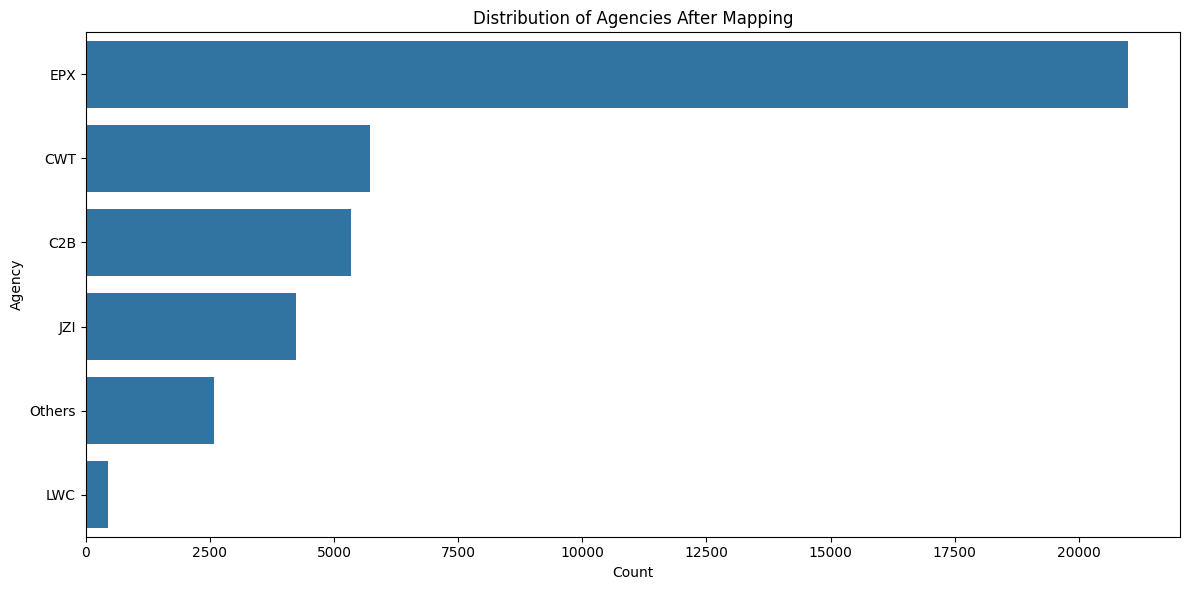

In [375]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x=df['Agency'].value_counts().values,
    y=df['Agency'].value_counts().index
)
plt.title('Distribution of Agencies After Mapping')
plt.xlabel('Count')
plt.ylabel('Agency')
plt.tight_layout()
plt.show()

In [376]:
agency_distribution = pd.DataFrame({
    'Agency': df['Agency'].value_counts().index,
    'Count': df['Agency'].value_counts().values,
    'Percentage': (df['Agency'].value_counts(normalize=True) * 100).round(2).values
})

agency_distribution

,Agency,Count,Percentage
0,EPX,20990,53.38
1,CWT,5726,14.56
2,C2B,5334,13.56
3,JZI,4233,10.76
4,Others,2589,6.58
5,LWC,452,1.15


In [377]:
claim_rates_agency = (df.groupby('Agency')['Claim'].mean() * 100).round(2)
selected_claim_rates = claim_rates_agency.loc[['JZI', 'Others']]
display(selected_claim_rates)

Agency
JZI       0.52
Others    0.85
Name: Claim, dtype: float64

Is it better to keep JZI separate or merge it into Others to possibly improve model accuracy ?

- **JZI represents ~10.8% of data**, larger than the combined 'Others' (~6.8%), making it a substantial segment.
- Claim rates differ significantly:
  - JZI claim rate: **0.51%**
  - Others claim rate: **0.81%**

- The lower claim rate for JZI indicates distinct risk behavior compared to Others.
- **Keeping JZI separate** preserves important predictive signals and enhances model accuracy.
- Merging JZI into Others would dilute meaningful differences and reduce interpretability.
- **Retaining JZI as a standalone category** would be better for business insights and improved modeling.

##### `Agency Type`

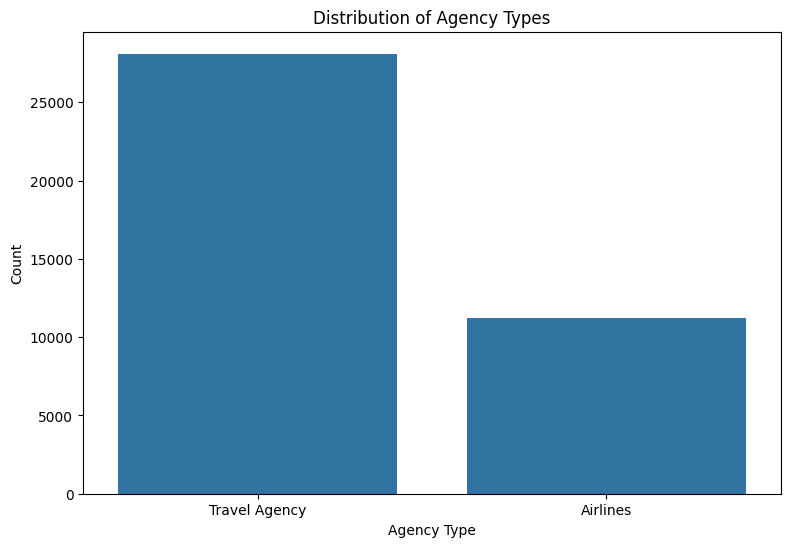

In [378]:
plt.figure(figsize=(9, 6))
sns.countplot(data=df, x='Agency Type', order=df['Agency Type'].value_counts().index)
plt.title('Distribution of Agency Types')
plt.xlabel('Agency Type')
plt.ylabel('Count')
plt.show()

##### `Distribution Channel`

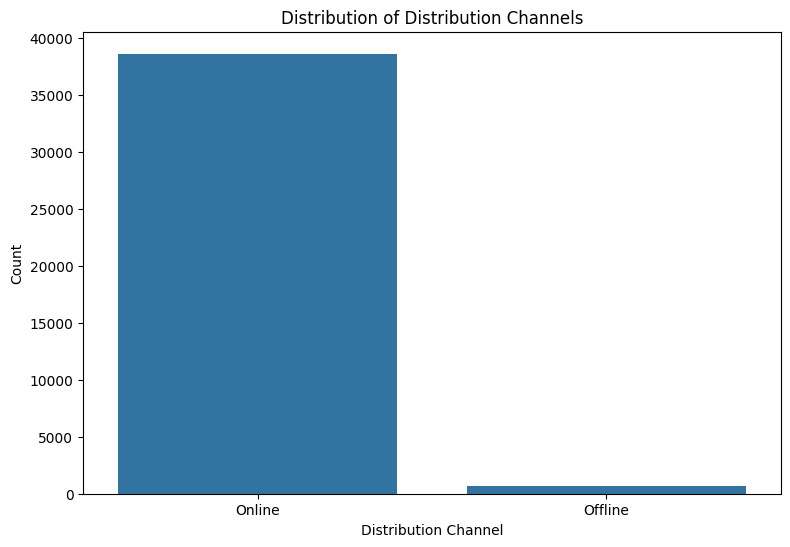

In [379]:
plt.figure(figsize=(9, 6))
sns.countplot(data=df, x='Distribution Channel', order=df['Distribution Channel'].value_counts().index)
plt.title('Distribution of Distribution Channels')
plt.xlabel('Distribution Channel')
plt.ylabel('Count')
plt.show()

##### `Product Name`

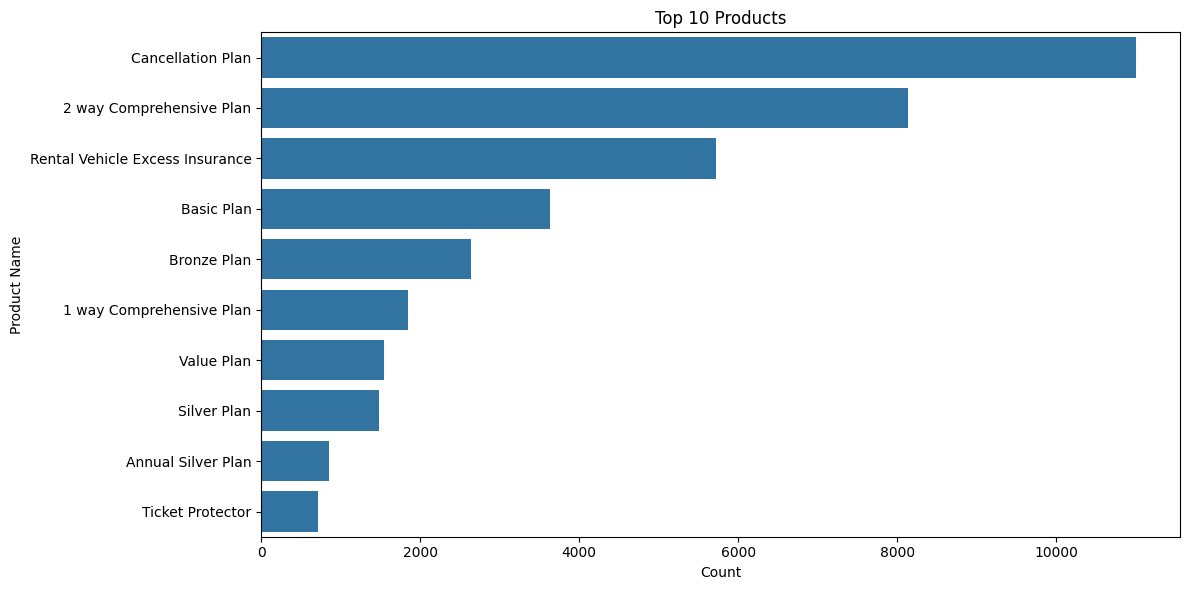

In [380]:
top_10_products = df['Product Name'].value_counts().nlargest(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_products.values, y=top_10_products.index)
plt.title('Top 10 Products')
plt.xlabel('Count')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()

In [381]:
product_claim_distribution = (
    pd.crosstab(df['Product Name'], df['Claim'], normalize='all') * 100
).round(2).sort_values(1, ascending=False)

html = product_claim_distribution.to_html()
scrollable_html = f'''
<div style='height:500px; overflow:auto;'>
{html}
</div>
'''

display(HTML(scrollable_html))

Claim,0,1
Product Name,,
Bronze Plan,6.29,0.41
Annual Silver Plan,1.89,0.27
Silver Plan,3.49,0.27
2 way Comprehensive Plan,20.44,0.24
Rental Vehicle Excess Insurance,14.40,0.16
Cancellation Plan,27.92,0.08
Value Plan,3.90,0.04
Basic Plan,9.21,0.04
Annual Gold Plan,0.31,0.04


In [382]:
claim_counts = df.groupby('Product Name')['Claim'].count().sort_values(ascending=False)
claim_percentages = (claim_counts / claim_counts.sum() * 100).round(2)

claim_summary = pd.DataFrame({
    'Count': claim_counts,
    'Percentage': claim_percentages
})

html_table = claim_summary.to_html()
scrollable_table_html = f'''
<div style='height:500px; overflow:auto;'>
{html_table}
</div>
'''

display(HTML(scrollable_table_html))

,Count,Percentage
Product Name,,
Cancellation Plan,11009,28.00
2 way Comprehensive Plan,8133,20.68
Rental Vehicle Excess Insurance,5726,14.56
Basic Plan,3638,9.25
Bronze Plan,2634,6.70
1 way Comprehensive Plan,1848,4.70
Value Plan,1549,3.94
Silver Plan,1480,3.76
Annual Silver Plan,849,2.16


In [383]:
product_claim_rates = (df.groupby('Product Name')['Claim'].mean() * 100).round(2).sort_values(ascending=False)
product_claim_rates_df = product_claim_rates.to_frame().rename(columns={'Claim': 'Claim Rate'})

html_table = product_claim_rates_df.to_html()
scrollable_html = f'''
<div style='height:500px; overflow:auto;'>
{html_table}
</div>
'''

display(HTML(scrollable_html))

,Claim Rate
Product Name,
Annual Silver Plan,12.60
Annual Gold Plan,11.76
Annual Travel Protect Gold,11.29
Single Trip Travel Protect Platinum,10.64
Spouse or Parents Comprehensive Plan,7.69
Silver Plan,7.30
Annual Travel Protect Silver,6.78
Bronze Plan,6.07
Annual Travel Protect Platinum,5.88


In [384]:
def mapping_product(x):
    keep = {
        'Annual Silver Plan', 'Annual Gold Plan', 'Annual Travel Protect Gold',
        'Single Trip Travel Protect Platinum', 'Spouse or Parents Comprehensive Plan',
        'Silver Plan', 'Annual Travel Protect Silver', 'Bronze Plan',
        'Annual Travel Protect Platinum', 'Single Trip Travel Protect Gold',
        'Gold Plan', 'Single Trip Travel Protect Silver', 'Comprehensive Plan',
        'Premier Plan', '2 way Comprehensive Plan', 'Rental Vehicle Excess Insurance'
    }
    return x if x in keep else 'Others'

df['Product Name'] = df['Product Name'].apply(mapping_product)

print('Below are the unique values of Product Name after mapping :')
display(sorted(df['Product Name'].unique()))
print(f"There are now {len(df['Product Name'].unique())} unique values of Product Name.")

Below are the unique values of Product Name after mapping :


['2 way Comprehensive Plan',
 'Annual Gold Plan',
 'Annual Silver Plan',
 'Annual Travel Protect Gold',
 'Annual Travel Protect Platinum',
 'Annual Travel Protect Silver',
 'Bronze Plan',
 'Comprehensive Plan',
 'Gold Plan',
 'Others',
 'Premier Plan',
 'Rental Vehicle Excess Insurance',
 'Silver Plan',
 'Single Trip Travel Protect Gold',
 'Single Trip Travel Protect Platinum',
 'Single Trip Travel Protect Silver',
 'Spouse or Parents Comprehensive Plan']

There are now 17 unique values of Product Name.


- Products with **claim rates below 1%** (0.01) are grouped into 'Others' to reduce feature cardinality.
- These low-claim-rate products contribute **very little to the positive class**, limiting their predictive power.
- Grouping helps to:
  - **Simplify the model**, making it less prone to overfitting.
  - **Improve model generalization** by avoiding sparse categories.
  - **Reduce noise** from rare product categories that may not have enough data for meaningful learning.
  
- Products with higher claim rates (≥ 1%) are retained as separate categories to preserve important signals.
- This balance ensures the model captures key distinctions while maintaining robustness.

##### `Destination`

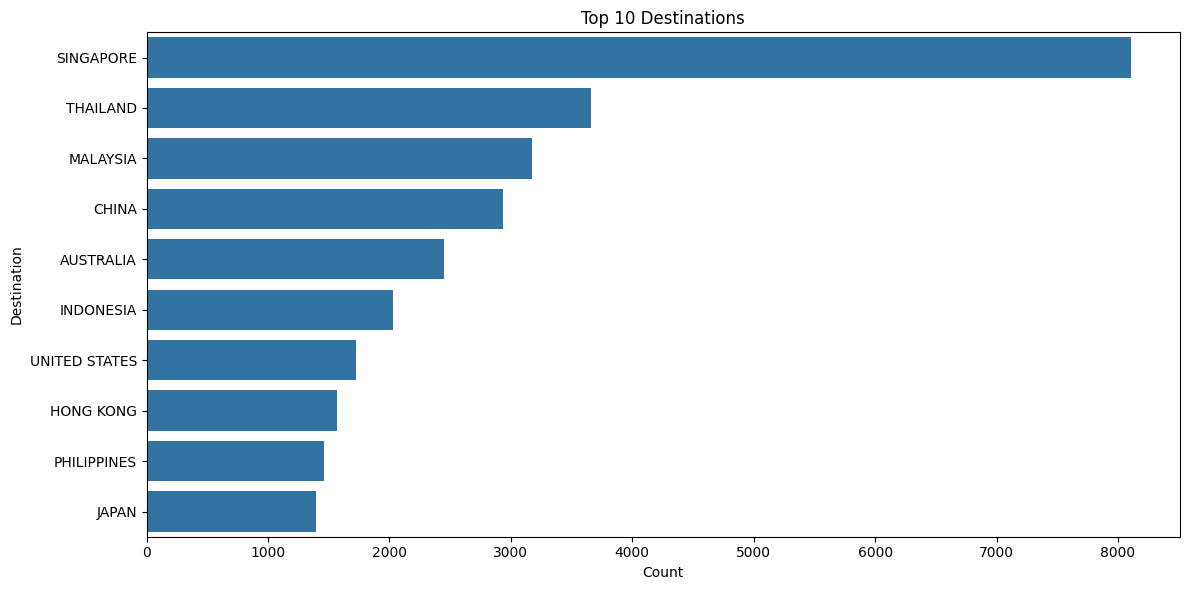

In [385]:
top_10_destinations = df['Destination'].value_counts().nlargest(10).index

plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Destination', order=top_10_destinations)
plt.title('Top 10 Destinations')
plt.xlabel('Count')
plt.ylabel('Destination')
plt.tight_layout()
plt.show()

* **Top 10 Destinations by Count :** This bar chart illustrates the top 10 most frequent destinations in the dataset, ordered from highest to lowest count.

    * **Leading Destination :** 'SINGAPORE' is the most prevalent destination, significantly exceeding all other entries with a count exceeding 8,000. This indicates a very high volume of instances related to Singapore.

    * **Prominent Destinations :** 'THAILAND' and 'MALAYSIA' follow, with counts around 3,500 to 4,000, signifying their substantial presence in the dataset.

    * **Mid-Range Destinations :** Countries like 'CHINA', 'AUSTRALIA', 'INDONESIA', 'UNITED STATES', and 'HONG KONG' fall into a middle tier, with counts ranging from approximately 1,500 to 3,000.

    * **Lower End of Top 10 :** 'PHILIPPINES' and 'JAPAN' complete the top 10, each with counts below 1,500.

* **Key Takeaway :** The distribution is heavily skewed towards Singapore, with a rapid drop-off to the next most common destinations. This suggests that Singapore is a primary focus or origin point within the dataset, warranting particular attention in any analysis or modeling.

In [386]:
destination_claim_distribution = (
    pd.crosstab(df['Destination'], df['Claim'], normalize='all') * 100
).round(2).sort_values(1, ascending=False)

html = destination_claim_distribution.to_html()
scrollable_html = f'''
<div style='height:500px; overflow:auto;'>
{html}
</div>
'''

display(HTML(scrollable_html))

Claim,0,1
Destination,,
SINGAPORE,19.56,1.05
AUSTRALIA,6.16,0.08
CHINA,7.37,0.08
UNITED STATES,4.31,0.07
THAILAND,9.24,0.06
MALAYSIA,8.03,0.04
INDONESIA,5.13,0.03
JAPAN,3.52,0.03
"KOREA, REPUBLIC OF",2.52,0.03


- Destinations with **claim rates below 0.02%**, will be grouped into 'Others'.
- This grouping reduces noise from rare categories and helps prevent models from overfitting.
- Destinations with a higher claim rate (e.g., Singapore, Australia, China, USA, Thailand) will be kept separate.
- Panama, Nigeria, Oman, Venezuela, Zambia are examples of low-claim & low-frequency destinations, which will be grouped into 'Others'.
- Grouping will help in improving the model generalization and simplify it for downstream analysis.

In [387]:
claim_counts_dest = df.groupby('Destination')['Claim'].count().sort_values(ascending=False)
claim_percentages_dest = (claim_counts_dest / claim_counts_dest.sum() * 100).round(2)

claim_summary_dest = pd.DataFrame({
    'Count': claim_counts_dest,
    'Percentage': claim_percentages_dest
})

html_table_dest = claim_summary_dest.to_html()
scrollable_table_html_dest = f'''
<div style='height:500px; overflow:auto;'>
{html_table_dest}
</div>
'''

display(HTML(scrollable_table_html_dest))

,Count,Percentage
Destination,,
SINGAPORE,8106,20.61
THAILAND,3659,9.30
MALAYSIA,3173,8.07
CHINA,2931,7.45
AUSTRALIA,2453,6.24
INDONESIA,2029,5.16
UNITED STATES,1723,4.38
HONG KONG,1570,3.99
PHILIPPINES,1461,3.72


In [388]:
destination_claim_rates = (df.groupby('Destination')['Claim'].mean() * 100).round(2).sort_values(ascending=False)
destination_claim_rates_df = destination_claim_rates.to_frame().rename(columns={'Claim': 'Claim Rate'})

html_table_dest = destination_claim_rates_df.to_html()
scrollable_html_dest = f'''
<div style='height:500px; overflow:auto;'>
{html_table_dest}
</div>
'''

display(HTML(scrollable_html_dest))

,Claim Rate
Destination,
COSTA RICA,25.00
SINGAPORE,5.09
CZECH REPUBLIC,4.65
ICELAND,3.85
ISRAEL,3.03
TURKEY,1.96
ITALY,1.94
FRANCE,1.81
SOUTH AFRICA,1.77


In [389]:
def mapping_destination(x):
    keep = {
        'SINGAPORE', 'CHINA', 'AUSTRALIA', 'UNITED STATES', 'THAILAND',
        'MALAYSIA', 'KOREA, REPUBLIC OF', 'INDONESIA', 'JAPAN', 'UNITED KINGDOM',
        'HONG KONG', 'PHILIPPINES', 'INDIA', 'ITALY', 'VIET NAM', 'FRANCE'
    }
    return x if x in keep else 'OTHERS'

df['Destination'] = df['Destination'].apply(mapping_destination)

print('Below are the unique values of Destination after mapping :')
display(sorted(df['Destination'].unique()))
print(f"There are now {len(df['Destination'].unique())} unique values of Destination.")

Below are the unique values of Destination after mapping :


['AUSTRALIA',
 'CHINA',
 'FRANCE',
 'HONG KONG',
 'INDIA',
 'INDONESIA',
 'ITALY',
 'JAPAN',
 'KOREA, REPUBLIC OF',
 'MALAYSIA',
 'OTHERS',
 'PHILIPPINES',
 'SINGAPORE',
 'THAILAND',
 'UNITED KINGDOM',
 'UNITED STATES',
 'VIET NAM']

There are now 17 unique values of Destination.


In [390]:
listItem = []
for col in df.columns :
    listItem.append([col,
                     df[col].dtype,
                     df[col].isna().sum(),
                     round((df[col].isna().sum()/len(df[col])) * 100,2),
                     df[col].nunique(), list(df[col].drop_duplicates().head(3).values)]); 

dfDesc = pd.DataFrame(columns=['Feature', 'Data Type', 'Missing Values', 'Percentage of Missing Values', 'Number of Unique Values', 'Sample'],
                      data=listItem)
dfDesc

,Feature,Data Type,Missing Values,Percentage of Missing Values,Number of Unique Values,Sample
0,Agency,object,0,0.0,6,"[C2B, EPX, JZI]"
1,Agency Type,object,0,0.0,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,0,0.0,2,"[Online, Offline]"
3,Product Name,object,0,0.0,17,"[Annual Silver Plan, Others, 2 way Comprehensive Plan]"
4,Duration,int64,0,0.0,437,"[365, 4, 19]"
5,Destination,object,0,0.0,17,"[SINGAPORE, MALAYSIA, INDIA]"
6,Net Sales,float64,0,0.0,1006,"[216.0, 10.0, 22.0]"
7,Commision (in value),float64,0,0.0,915,"[54.0, 0.0, 7.7]"
8,Age,int64,0,0.0,89,"[57, 33, 26]"
9,Claim,int64,0,0.0,2,"[0, 1]"


##### EDA for Categorical Features

In [456]:
categorical_features = ['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Destination']

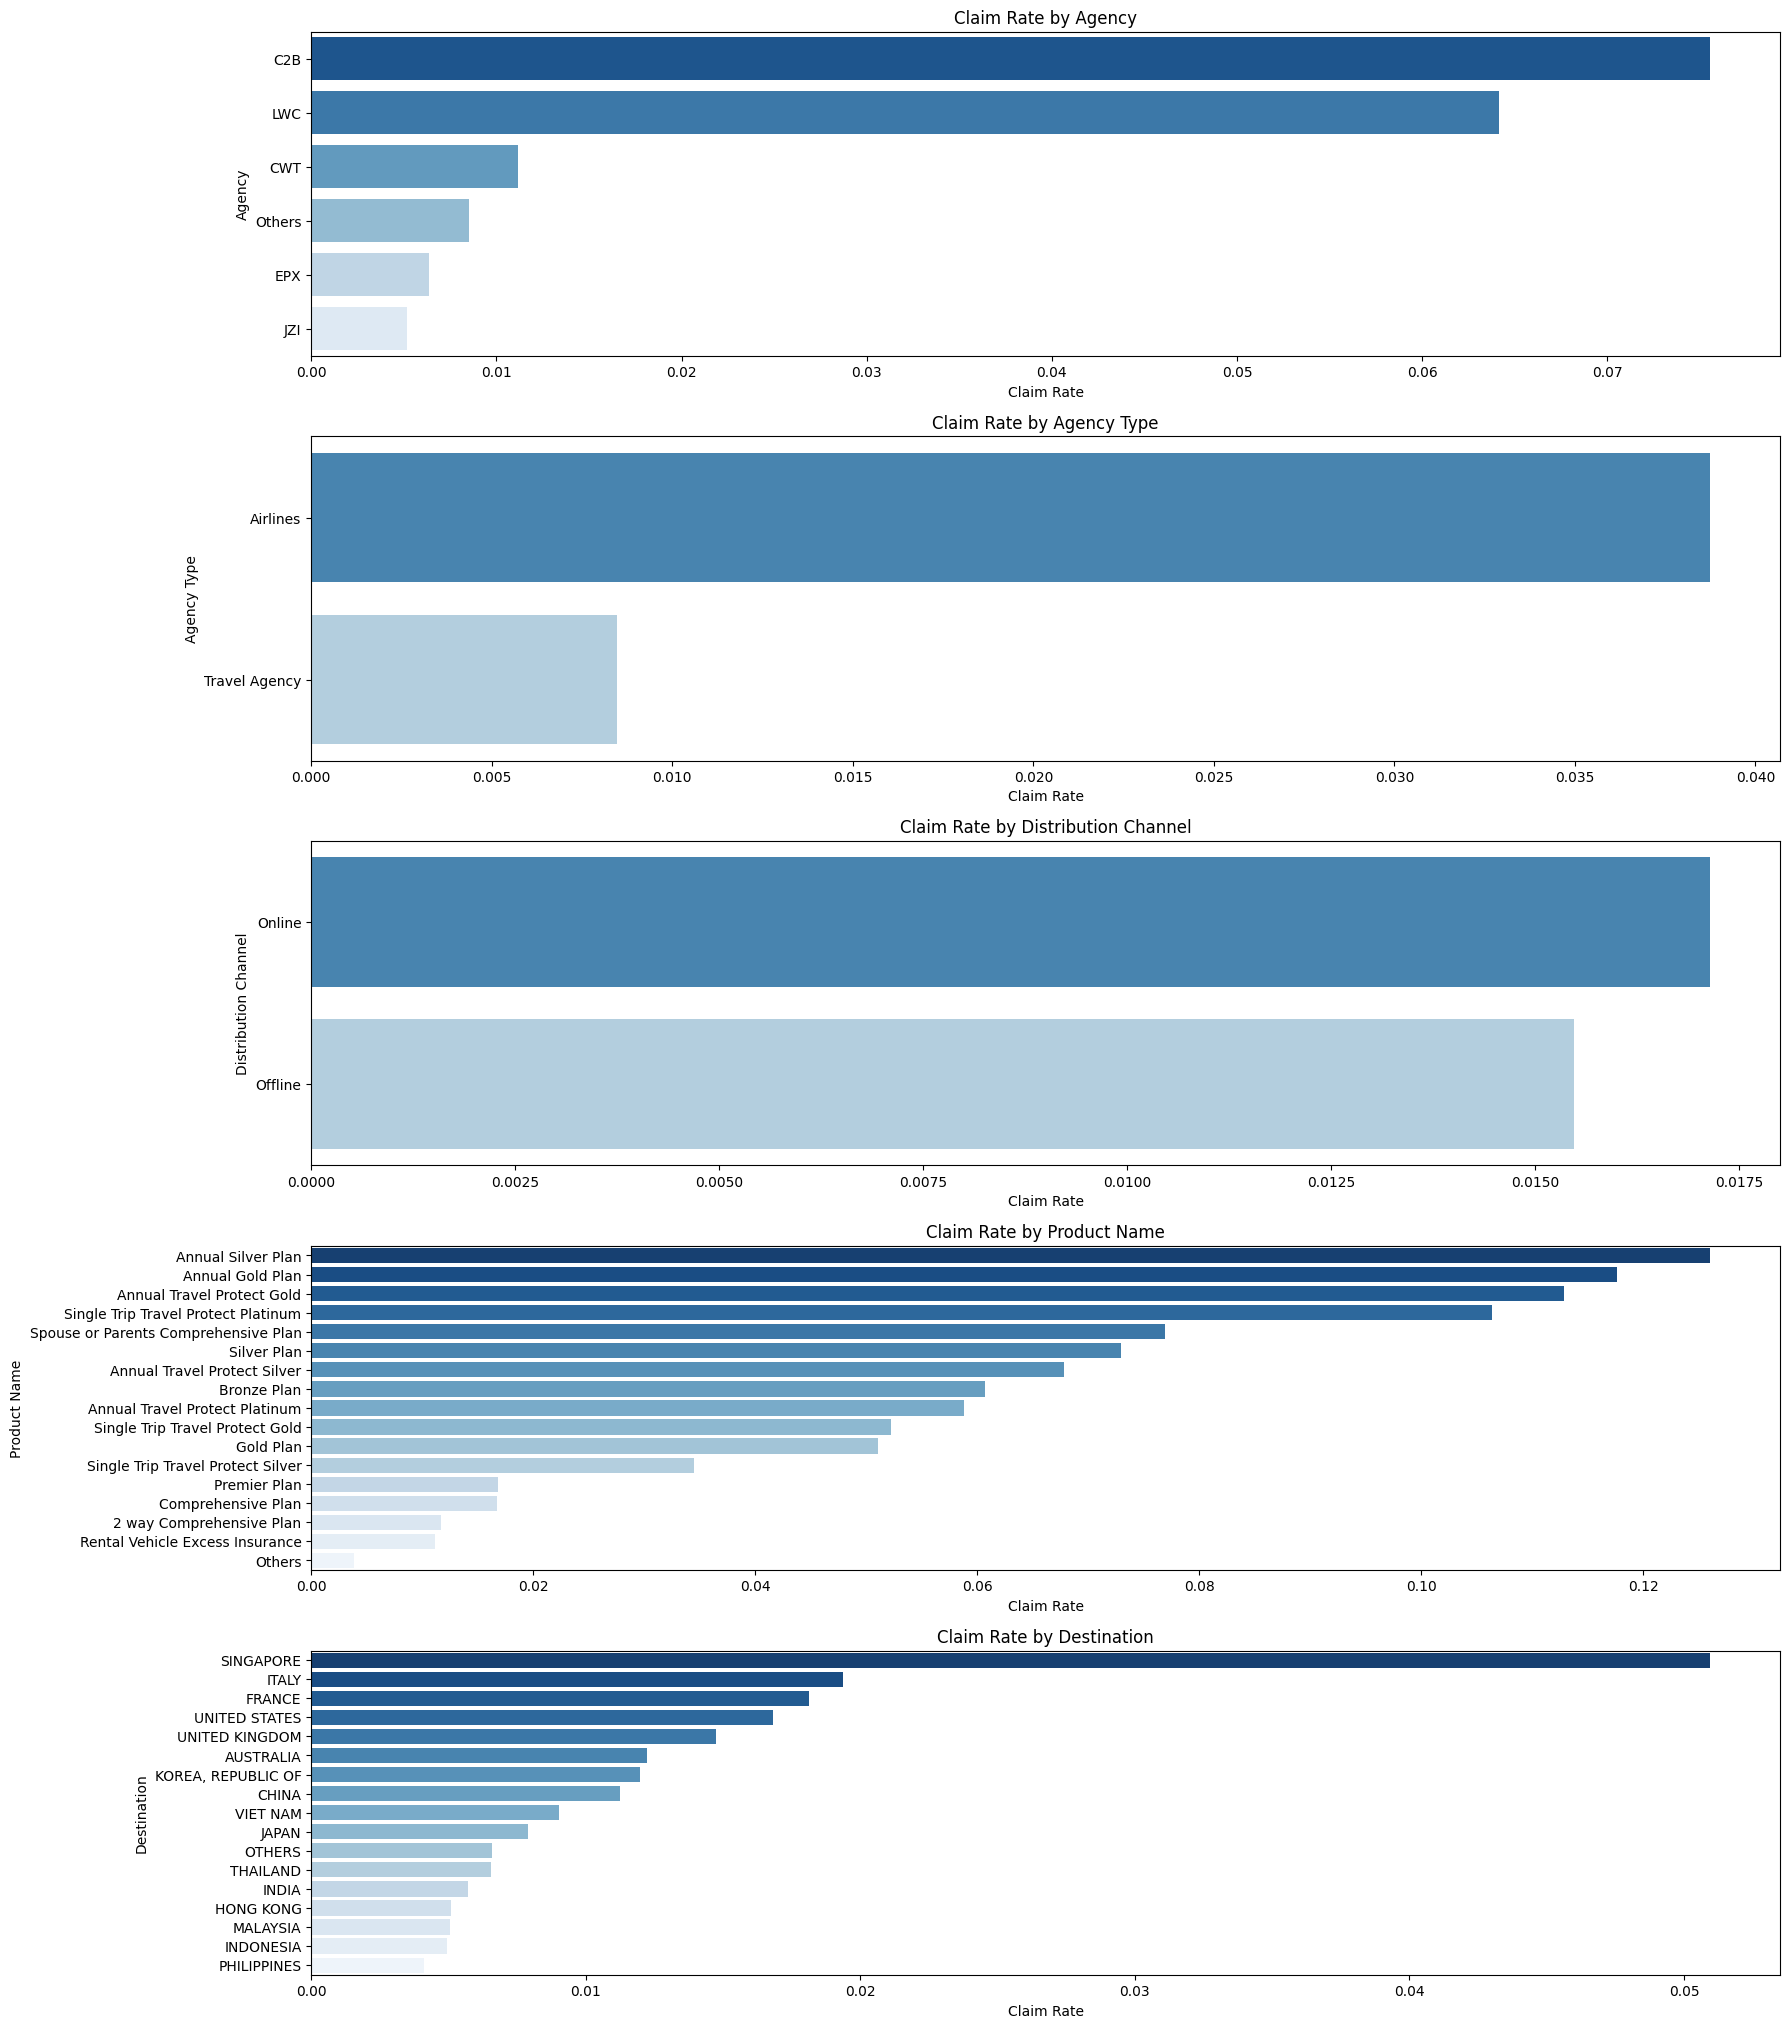

In [472]:
plt.figure(figsize=(18, 24))

for i, col in enumerate(categorical_features, 1):
    plt.subplot(6, 1, i)
    claim_rate = df.groupby(col)['Claim'].mean().sort_values(ascending=False)
    sns.barplot(x=claim_rate.values, y=claim_rate.index, palette='Blues_r')
    plt.title(f'Claim Rate by {col}')
    plt.xlabel('Claim Rate')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

* **Claim Rate by Key Features :** This visualization illustrates the *claim rate* (proportion of claims) across various categorical features, providing a normalized view of risk associated with each category.

    * **Agency :** 'C2B' and 'LWC' agencies show the highest claim rates, both exceeding 6%, suggesting higher risk profiles compared to other agencies like 'EPX' and 'JZI'.

    * **Agency Type :** 'Airlines' exhibits a significantly higher claim rate (approximately 3.8%) compared to 'Travel Agency' (around 0.8%).

    * **Distribution Channel :** The 'Online' channel has a notably higher claim rate (around 1.7%) than the 'Offline' channel (approximately 1.5%).

    * **Product Name :** 'Annual Silver Plan' and 'Annual Travel Protect Silver' have the highest claim rates, both above 11%, indicating a higher likelihood of claims for these products. The claim rates vary significantly across different product types.

    * **Destination :** 'SINGAPORE' and 'UNITED KINGDOM' show the highest claim rates among destinations, both around 2.0% to 2.2%. Claim rates vary considerably across countries, with some like 'PHILIPPINES' having much lower rates.

* **Key Takeaway :** The claim rate charts pinpoint specific categories within each feature that are associated with a higher propensity for claims. This information is critical for risk assessment, pricing strategies, and targeted interventions in insurance claim prediction.

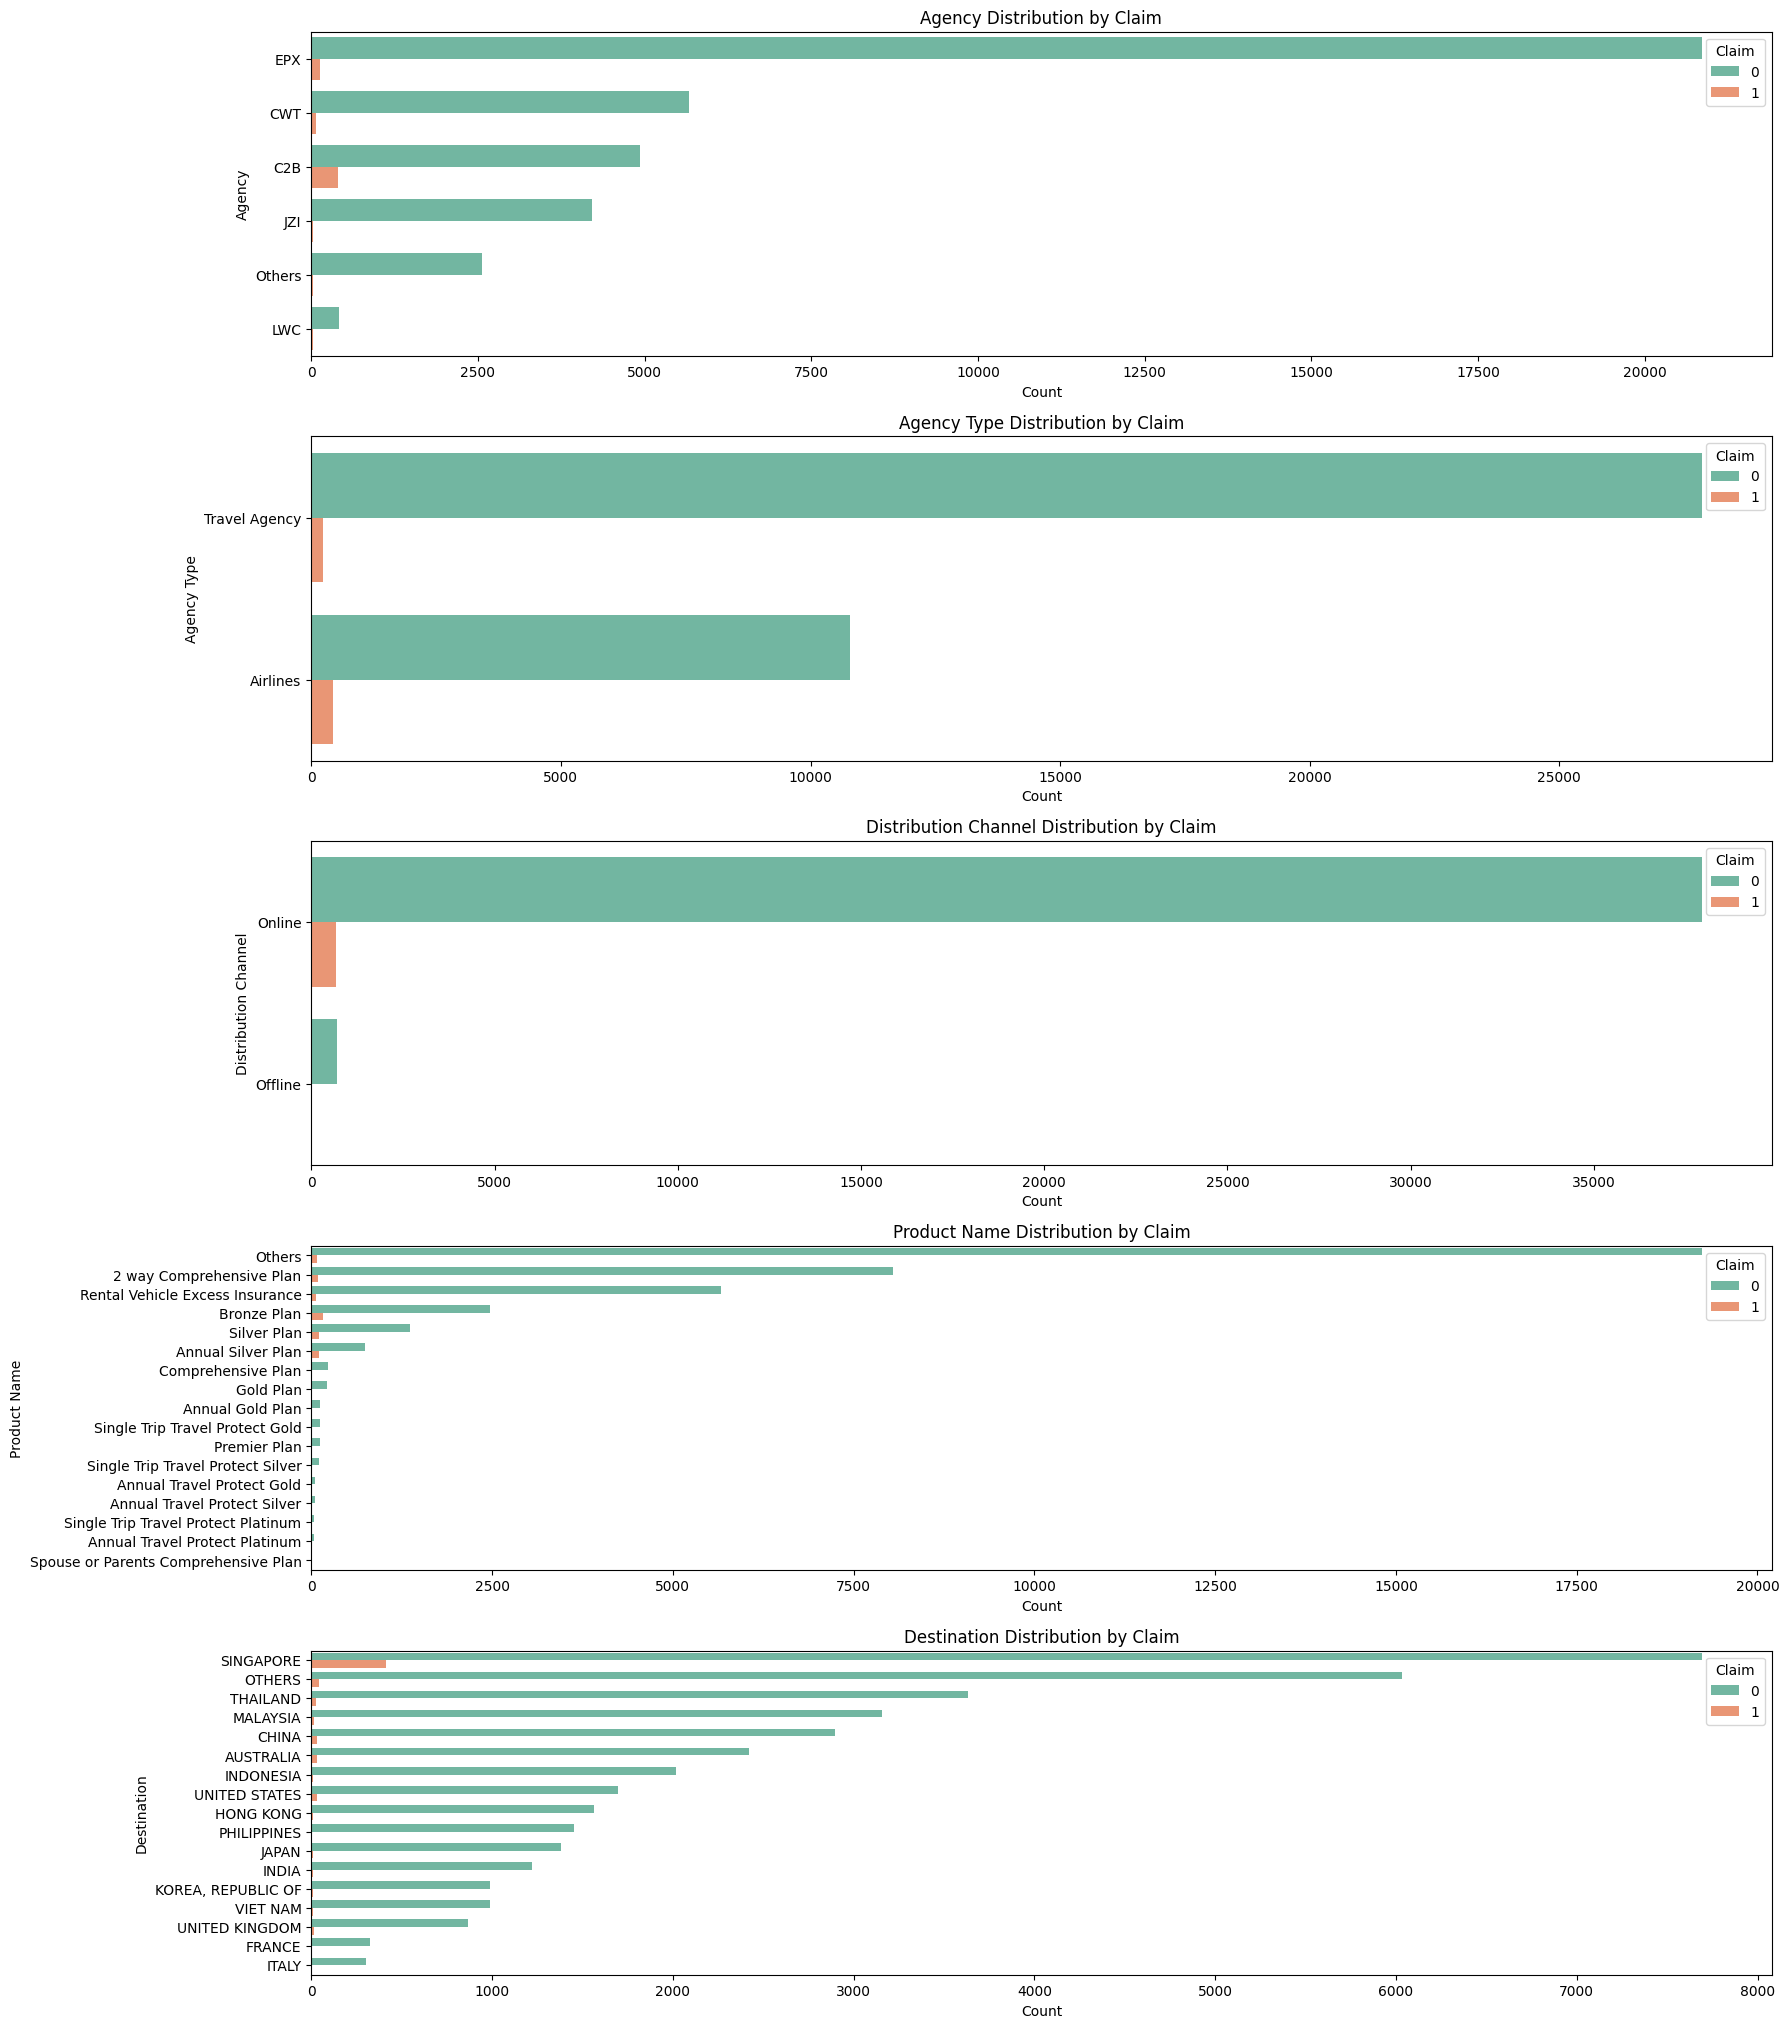

In [469]:
plt.figure(figsize=(18, 24))

for i, col in enumerate(categorical_features, 1):
    plt.subplot(6, 1, i)
    sns.countplot(data=df, y=col, hue='Claim', order=df[col].value_counts().index, palette='Set2')
    plt.title(f'{col} Distribution by Claim')
    plt.xlabel('Count')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

* **Claim Distribution by Key Features :** This visualization presents the distribution of insurance claims (labeled '1') versus non-claims (labeled '0') across several categorical features, offering insights into their relationship with claim occurrences.

    * **Agency & Agency Type :** 'EPX' agency and 'Travel Agency' type show the highest number of non-claims, but also a notable presence of claims. 'Airlines' has a substantial count of non-claims with fewer claims.

    * **Distribution Channel :** The 'Online' channel overwhelmingly dominates in both non-claims and claims compared to 'Offline'.

    * **Product Name :** 'Others' and '2 way Comprehensive Plan' are prominent in both claims and non-claims. Specific plans like 'Annual Gold Plan' and 'Premier Plan' also show a presence of claims.

    * **Destination :** 'SINGAPORE' and 'MALAYSIA' exhibit the highest overall counts, with claims present across various top destinations.

* **Key Takeaway :** The charts highlight the imbalance between claims and non-claims across all features. While the majority of entries are non-claims, the distributions reveal which categories contribute most to both claim and non-claim volumes, which is crucial for understanding risk factors and targeting.

In [473]:
print("\nClaim Rates by Category:")
for col in categorical_features:
    rate_table = df.groupby(col)['Claim'].agg(['count', 'sum', 'mean']).rename(
        columns={'count': 'Total', 'sum': 'Claims', 'mean': 'Claim Rate'}).sort_values('Claim Rate', ascending=False)
    print(f"\n--- {col} ---")
    print(rate_table.head(10))


Claim Rates by Category:

--- Agency ---
        Total  Claims  Claim Rate
Agency                           
C2B      5334     403    0.075553
LWC       452      29    0.064159
CWT      5726      64    0.011177
Others   2589      22    0.008497
EPX     20990     133    0.006336
JZI      4233      22    0.005197

--- Agency Type ---
               Total  Claims  Claim Rate
Agency Type                             
Airlines       11228     435    0.038742
Travel Agency  28096     238    0.008471

--- Distribution Channel ---
                      Total  Claims  Claim Rate
Distribution Channel                           
Online                38613     662    0.017144
Offline                 711      11    0.015471

--- Product Name ---
                                      Total  Claims  Claim Rate
Product Name                                                   
Annual Silver Plan                      849     107    0.126031
Annual Gold Plan                        136      16    0.117647
A

- **Airline agencies have significantly higher claim rates** (3.87%) compared to travel agencies (0.85%), suggesting potential risk concentration or different product usage patterns.
- **Certain insurance products like the "Annual Silver Plan" and "Annual Gold Plan" exhibit notably high claim rates**, exceeding 11%, which may indicate higher exposure or coverage intensity.
- **The "C2B" and "LWC" agencies stand out with the highest claim rates** among all agencies, at 7.55% and 6.42% respectively — significantly above the overall average.
- **Destinations such as Singapore show a substantially elevated claim rate (5.1%)**, far exceeding most other popular destinations, warranting further review of travel-related risks or claim behaviors in that region.
- **Distribution channels show comparable claim rates**, with online at 1.71% and offline at 1.55%, indicating no major difference in risk based on how policies are purchased.

## **4. Data Preparation**

### Define Target (X) and Features (y)



In [391]:
X = df.drop(columns = 'Claim', axis = 1)
y = df['Claim']

### Train Test Split

In [392]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

### Pipeline

- **Scaling**:
    - `RobustScaler` : `Duration`, `Net Sales`, `Commision (in value)`
    - Binning (Ordinal Quantile) : `Age`

- **Encoding**:
    - OneHot Encoding : `Agency`, `Agency Type`, `Distribution Channel`, `Product Name`, `Destination`

In [393]:
df['Age'].describe().apply(lambda x: f'{x:.0f}')

count    39324
mean        40
std         13
min          0
25%         35
50%         36
75%         44
max        118
Name: Age, dtype: object

- The `Age` variable will be transformed using **quantile-based binning** with `KBinsDiscretizer`, creating **7 ordinal bins**.
- Quantile binning will ensure that each bin contains approximately the **same number of observations**, making it appropriate for skewed distributions.
- This approach will help capture **non-linear relationships** between age and the target variable while reducing the influence of outliers.
- **Ordinal encoding** will be applied to preserve the natural order of the age groups, which is beneficial for models that utilize ordinal information.
- Binning the age variable is expected to reduce granularity, mitigate noise, and enhance **model stability** and **generalization**.


In [394]:
# Encoders and Scalers
one_hot_encoder = OneHotEncoder(drop='first')
robust_scaler = RobustScaler()
age_binner = KBinsDiscretizer(
    n_bins=7,
    encode='ordinal',
    strategy='quantile'
)

# Column groups by preprocessing type
categorical_features = ['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Destination']
numerical_features = ['Duration', 'Net Sales', 'Commision (in value)']
age_feature = ['Age']

In [395]:
# Combined preprocessing transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot_encoding', one_hot_encoder, categorical_features),
        ('quantile_binning', age_binner, age_feature),
        ('robust_scaling', robust_scaler, numerical_features)
    ],
    remainder='passthrough'
)

## **5. Cross Validation**

In [396]:
num_negatives = np.sum(y == 0)
num_positives = np.sum(y == 1)
scale_pos_weight = num_negatives / num_positives

print(f"scale_pos_weight: {scale_pos_weight}")

scale_pos_weight: 57.43090638930163


- The code above calculates a number to be used as the `scale_pos_weight` parameter, which helps handle imbalance in the data.
- It looks at how many samples we have in the big group versus the small group, i.e., the positive and negative classes.
- The result, 57.43, means the big group is about 57 times bigger than the small one.
- This number tells the model to pay more attention to the smaller group during training.  
- That way, the model won’t ignore the rare cases and will make better predictions overall.

In [397]:
model_dict = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),

    "SVM": SVC(class_weight='balanced', probability=True, random_state=42),

    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),

    "Balanced Random Forest": BalancedRandomForestClassifier(random_state=42),

    "Gradient Boosting": GradientBoostingClassifier(random_state=42),

    "XGBoost": XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='aucpr',
        random_state=42
    ),

    "LightGBM": LGBMClassifier(is_unbalance=True, random_state=42),

    "CatBoost": CatBoostClassifier(
        class_weights=[1, scale_pos_weight],
        verbose=0,
        random_state=42
    ),

    "Easy Ensemble": EasyEnsembleClassifier(random_state=42),
}

**Model Explanations**

**Logistic Regression**  
- **What it is :** A linear model for binary classification that estimates the probability of a class using a logistic function.  
- **How it works :** Fits a linear decision boundary by maximizing the likelihood of observed data.  
- **Pros :** Simple, interpretable, fast to train, works well for linearly separable data.  
- **Cons :** Struggles with complex nonlinear patterns, sensitive to outliers.  

**SVM (Support Vector Machine)**  
- **What it is :** A classifier that finds the hyperplane maximizing the margin between classes.  
- **How it works :** Transforms data into higher dimensions (via kernels) and finds the best separating boundary.  
- **Pros :** Effective in high-dimensional spaces, works well with clear margin of separation.  
- **Cons :** Can be slow on large datasets, sensitive to parameter tuning, no direct probability estimates without extra steps.  

**Random Forest**  
- **What it is :** An ensemble of decision trees trained on random subsets of data/features.  
- **How it works :** Aggregates predictions from many trees to reduce overfitting and improve accuracy.  
- **Pros :** Handles nonlinear data well, robust to overfitting, works with missing values.  
- **Cons :** Can be slow for large forests, less interpretable than single trees.  

**Balanced Random Forest**  
- **What it is :** A variation of Random Forest designed for imbalanced datasets by balancing classes during tree construction.  
- **How it works :** Balances the class distribution in each bootstrap sample, improving minority class learning.  
- **Pros :** Better performance on imbalanced data, retains Random Forest advantages.  
- **Cons :** Slightly increased computational cost, less interpretable.  

**Gradient Boosting**  
- **What it is :** An ensemble method building trees sequentially, where each tree corrects errors of the previous one.  
- **How it works :** Optimizes a loss function by adding trees that focus on difficult samples.  
- **Pros :** High predictive accuracy, handles complex data patterns.  
- **Cons :** Longer training time, sensitive to hyperparameters, prone to overfitting without tuning.  

**XGBoost**  
- **What it is :** An optimized, scalable implementation of gradient boosting with regularization.  
- **How it works :** Uses advanced regularization and parallelization for faster, more accurate boosting.  
- **Pros :** Excellent performance, handles missing data, supports weighted classes (scale_pos_weight).  
- **Cons :** Complex to tune, can overfit without care.  

**LightGBM**  
- **What it is :** A gradient boosting framework using tree-based learning with a focus on speed and efficiency.  
- **How it works :** Uses histogram-based algorithms and leaf-wise tree growth to speed up training.  
- **Pros :** Very fast training, handles large datasets, built-in support for unbalanced data.  
- **Cons :** May overfit on small datasets, less interpretable.  

**CatBoost**  
- **What it is :** Gradient boosting algorithm that handles categorical features automatically.  
- **How it works :** Uses ordered boosting and specialized techniques to reduce overfitting and handle categorical data.  
- **Pros :** Handles categorical variables without preprocessing, robust to overfitting, good default parameters.  
- **Cons :** Training can be slower, requires more memory.  

**Easy Ensemble**  
- **What it is :** An ensemble method that combines multiple balanced subsets of the data with AdaBoost.  
- **How it works :** Trains AdaBoost classifiers on balanced bootstrap samples of the majority and minority classes.  
- **Pros :** Effective for highly imbalanced datasets, improves minority class detection.  
- **Cons :** Computationally expensive, complexity in ensemble interpretation.

In [398]:
list_all_scores = []
list_mean_scores = []
list_std_scores = []

for name, model in model_dict.items():
    
    pipe_prep_model = Pipeline([
        ('preprocessing', preprocessor),
        ('modeling', model)
    ])
    
    crossval = cross_val_score(
        estimator=pipe_prep_model,
        X=X_train,
        y=y_train,
        cv=5,
        scoring='recall',
        n_jobs=-1
    )
    
    list_all_scores.append(crossval.round(2))
    list_mean_scores.append(crossval.mean())
    list_std_scores.append(crossval.std())

In [399]:
df_recall = pd.DataFrame()
df_recall['algorithm'] = list(model_dict.keys())
df_recall['all_scores'] = list_all_scores
df_recall['mean_score'] = list_mean_scores
df_recall['std_score'] = list_std_scores

df_recall.sort_values(by='mean_score', ascending=False)

,algorithm,all_scores,mean_score,std_score
8,Easy Ensemble,"[0.77, 0.75, 0.7, 0.68, 0.72]",0.723122,0.032275
0,Logistic Regression,"[0.73, 0.75, 0.67, 0.64, 0.7]",0.697092,0.040358
1,SVM,"[0.73, 0.72, 0.67, 0.66, 0.66]",0.687764,0.031107
3,Balanced Random Forest,"[0.71, 0.69, 0.66, 0.64, 0.71]",0.680408,0.028497
6,LightGBM,"[0.6, 0.48, 0.54, 0.53, 0.52]",0.533558,0.037499
7,CatBoost,"[0.49, 0.46, 0.43, 0.45, 0.39]",0.444219,0.032226
5,XGBoost,"[0.42, 0.44, 0.41, 0.4, 0.36]",0.405140,0.029450
2,Random Forest,"[0.07, 0.13, 0.04, 0.06, 0.08]",0.074351,0.031548
4,Gradient Boosting,"[0.01, 0.0, 0.0, 0.0, 0.01]",0.003738,0.004578


<img src='EasyEnsemble.PNG' width='40%'>

The image taken from [here](https://i.sstatic.net/W7UmY.png).

Please refer to the image above for a visual representation of how the `EasyEnsembleClassifier` functions.

Below is a more formal and concise explanation of the `EasyEnsembleClassifier`, which will serve as the primary model for the hyperparameter tuning process:

- The bottom layer of the diagram represents multiple **diverse predictors**, each being an individual machine learning model trained on a different balanced subset of the data. These subsets are typically generated through undersampling of the majority class.

- A **new instance** (i.e., an unseen data point) is simultaneously passed through each of these base learners.

- Each predictor independently generates a **prediction** for the given instance. In the illustrated example, three of the predictors return a prediction of '1', while one returns '2'.

- The final prediction from the `EasyEnsembleClassifier` is determined by aggregating the outputs of all base learners, commonly using a **majority voting** mechanism. In this case, the ensemble predicts '1' as it is the majority vote.

- By combining the outputs of several slightly varied models, the `EasyEnsembleClassifier` enhances predictive performance and robustness, particularly in the context of **imbalanced datasets**. This ensemble strategy reduces the bias associated with training a single model and mitigates the risk of overlooking minority class instances.

## **6. Hyperparameter Tuning**

**EasyEnsembleClassifier parameters :**

- `n_estimators`  
  - Number of AdaBoost ensemble classifiers in the ensemble.  
  - ↑ More estimators → more diverse ensemble → may improve generalization, reduce overfitting.  
  - ↓ Fewer estimators → faster training but may underfit.

- `sampling_strategy`  
  - Ratio of minority class to majority class after resampling.  
  - ↑ Higher ratio (closer to 1) → more balanced classes → may reduce bias.  
  - ↓ Lower ratio → aggressive undersampling → risk of overfitting to minority class.

- `replacement`  
  - Whether sampling is done with replacement.  
  - `True` → allows repeated samples → can lead to overfitting on duplicated data.  
  - `False` → each sample is unique → generally better generalization.

- `warm_start`  
  - Whether to reuse the solution of the previous call to `fit`.  
  - `True` → builds on previous training → useful for incremental learning.  
  - `False` → starts fresh every time → no carryover effects → neutral for overfitting.

**AdaBoostClassifier parameters (base estimator) :**

- `estimator__n_estimators`  
  - Number of weak learners (e.g., decision trees) in each AdaBoost classifier.  
  - ↑ More learners → more complex AdaBoost model → may lead to overfitting.  
  - ↓ Fewer learners → simpler model → may underfit.

- `estimator__learning_rate`  
  - Shrinks the contribution of each new weak learner.  
  - ↑ Higher rate → faster learning → more sensitivity to noise → prone to overfitting.  
  - ↓ Lower rate → slower, more stable learning → less risk of overfitting.

- `estimator__algorithm` 
  - 'SAMME' → uses predicted class labels → more conservative → may reduce overfitting.


References :
- [EasyEnsembleClassifier](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.EasyEnsembleClassifier.html)
- [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

### EasyEnsemble with AdaBoost

In [400]:
base_estimator = AdaBoostClassifier(algorithm='SAMME', random_state=42)
model = EasyEnsembleClassifier(estimator=base_estimator, random_state=42)

param_grid = {
    'modeling__n_estimators': [100, 125, 150, 175, 200],
    'modeling__estimator__n_estimators': [50, 75, 100, 125],
    'modeling__estimator__learning_rate': [0.005, 0.01, 0.02, 0.05],
    'modeling__estimator__algorithm': ['SAMME'],
    'modeling__sampling_strategy': ['auto', 0.8, 0.9],
    'modeling__replacement': [False],
    'modeling__warm_start': [False]
}

- The code above uses `AdaBoostClassifier` as the base model inside the **EasyEnsembleClassifier**.  
- **EasyEnsemble** works by creating several **balanced subsets** of the data and training a model on each one.  
- Instead of using a simple model like a decision tree, we use `AdaBoostClassifier`, which in itself is an **ensemble method**.  
- `AdaBoostClassifier` improves accuracy by focusing more on the **mistakes from previous rounds**.  
- So for each subset, we train a **stronger model** that keeps adjusting based on where it made errors before.  
- This combination helps the overall system perform **better**, especially on **tough, imbalanced datasets**.

In [401]:
pipe_prep_model = Pipeline([
    ('preprocessing', preprocessor),
    ('modeling', model)])

gridsearch = GridSearchCV(
    estimator = pipe_prep_model,
    cv = 5,
    n_jobs = -1,
    param_grid = param_grid,
    scoring = 'recall'
)

In [402]:
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one_hot_encoding',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Agency',
                                                                          'Agency '
                                                                          'Type',
                                                                          'Distribution '
                                                                          'Channel',
                                                                          'Product '
                                                                          'Name',
                                                                          'Destination']),
                                                                        ('quantile_binning',
                                                                         KBinsDiscretizer(encode='ordinal',
                                                                                          n_bins=7),
                                                                         ['Age']),
                                                                        ('robust_scaling',
                                                                         RobustScaler(...
             n_jobs=-1,
             param_grid={'modeling__estimator__algorithm': ['SAMME'],
                         'modeling__estimator__learning_rate': [0.005, 0.01,
                                                                0.02, 0.05],
                         'modeling__estimator__n_estimators': [50, 75, 100,
                                                               125],
                         'modeling__n_estimators': [100, 125, 150, 175, 200],
                         'modeling__replacement': [False],
                         'modeling__sampling_strategy': ['auto', 0.8, 0.9],
                         'modeling__warm_start': [False]},
             scoring='recall')

In [403]:
gridsearch.best_score_

np.float64(0.7565939771547248)

In [404]:
gridsearch.best_params_

{'modeling__estimator__algorithm': 'SAMME',
 'modeling__estimator__learning_rate': 0.01,
 'modeling__estimator__n_estimators': 75,
 'modeling__n_estimators': 125,
 'modeling__replacement': False,
 'modeling__sampling_strategy': 'auto',
 'modeling__warm_start': False}

Best parameters for EasyEnsemble with AdaBoost:

{'modeling__estimator__algorithm': 'SAMME',
 'modeling__estimator__learning_rate': 0.01,
 'modeling__estimator__n_estimators': 75,
 'modeling__n_estimators': 125,
 'modeling__replacement': False,
 'modeling__sampling_strategy': 'auto',
 'modeling__warm_start': False}

### EasyEnsemble without AdaBoost

In [405]:
base_model = EasyEnsembleClassifier(random_state=42)

param_grid = {
    'modeling__n_estimators': [10, 20, 30, 50],
    'modeling__sampling_strategy': ['auto', 0.7, 0.9],
    'modeling__replacement': [False],
    'modeling__warm_start': [False]
}

In [406]:
pipe_prep_model = Pipeline([
    ('preprocessing', preprocessor),
    ('modeling', base_model)
])

base_gridsearch = GridSearchCV(
    estimator=pipe_prep_model,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1
)

In [407]:
base_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one_hot_encoding',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Agency',
                                                                          'Agency '
                                                                          'Type',
                                                                          'Distribution '
                                                                          'Channel',
                                                                          'Product '
                                                                          'Name',
                                                                          'Destination']),
                                                                        ('quantile_binning',
                                                                         KBinsDiscretizer(encode='ordinal',
                                                                                          n_bins=7),
                                                                         ['Age']),
                                                                        ('robust_scaling',
                                                                         RobustScaler(),
                                                                         ['Duration',
                                                                          'Net '
                                                                          'Sales',
                                                                          'Commision '
                                                                          '(in '
                                                                          'value)'])])),
                                       ('modeling',
                                        EasyEnsembleClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'modeling__n_estimators': [10, 20, 30, 50],
                         'modeling__replacement': [False],
                         'modeling__sampling_strategy': ['auto', 0.7, 0.9],
                         'modeling__warm_start': [False]},
             scoring='recall')

In [408]:
base_gridsearch.best_score_

np.float64(0.7268605053651782)

In [409]:
base_gridsearch.best_params_

{'modeling__n_estimators': 30,
 'modeling__replacement': False,
 'modeling__sampling_strategy': 'auto',
 'modeling__warm_start': False}

Best parameters for EasyEnsemble without AdaBoost:

{'modeling__n_estimators': 30,
 'modeling__replacement': False,
 'modeling__sampling_strategy': 'auto',
 'modeling__warm_start': False}

## **7. Predict to Test**

### Before Tuning - EasyEnsemble with AdaBoost

In [410]:
base_estimator = AdaBoostClassifier(algorithm='SAMME', random_state=42)
final_model = EasyEnsembleClassifier(estimator=base_estimator, random_state=42)

pipe_prep_model =  Pipeline([
        ('preprocessing', preprocessor),
        ('modeling', final_model)
    ])

pipe_prep_model.fit(X_train, y_train)

y_pred_before = pipe_prep_model.predict(X_test)

print(classification_report(y_test,y_pred_before))

              precision    recall  f1-score   support

           0       1.00      0.73      0.84      7730
           1       0.05      0.81      0.09       135

    accuracy                           0.73      7865
   macro avg       0.52      0.77      0.47      7865
weighted avg       0.98      0.73      0.83      7865



In [411]:
print(f'Recall score before tuning : {recall_score(y_test,y_pred_before)}')

Recall score before tuning : 0.8074074074074075


### After Tuning - EasyEnsemble with AdaBoost

In [412]:
best_model = gridsearch.best_estimator_

y_pred_after = best_model.predict(X_test)

print(classification_report(y_test,y_pred_after))

              precision    recall  f1-score   support

           0       0.99      0.70      0.82      7730
           1       0.04      0.75      0.08       135

    accuracy                           0.70      7865
   macro avg       0.52      0.73      0.45      7865
weighted avg       0.98      0.70      0.81      7865



In [413]:
print(f'Recall score before tuning : {recall_score(y_test,y_pred_before)}')
print(f'Recall score after tuning : {recall_score(y_test,y_pred_after)}')

Recall score before tuning : 0.8074074074074075
Recall score after tuning : 0.7481481481481481


### After Tuning - EasyEnsemble without AdaBoost

In [414]:
base_best_model = base_gridsearch.best_estimator_

y_pred_after_base = base_best_model.predict(X_test)

print(classification_report(y_test,y_pred_after_base))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86      7730
           1       0.05      0.78      0.10       135

    accuracy                           0.76      7865
   macro avg       0.52      0.77      0.48      7865
weighted avg       0.98      0.76      0.85      7865



In [415]:
print(f'Recall score before tuning : {recall_score(y_test,y_pred_before)}')
print(f'Recall score after tuning : {recall_score(y_test,y_pred_after)}')
print(f'Recall score after tuning without estimator : {recall_score(y_test,y_pred_after_base)}')

Recall score before tuning : 0.8074074074074075
Recall score after tuning : 0.7481481481481481
Recall score after tuning without estimator : 0.7777777777777778


## **8. Model Evaluation**

### Confusion Matrix

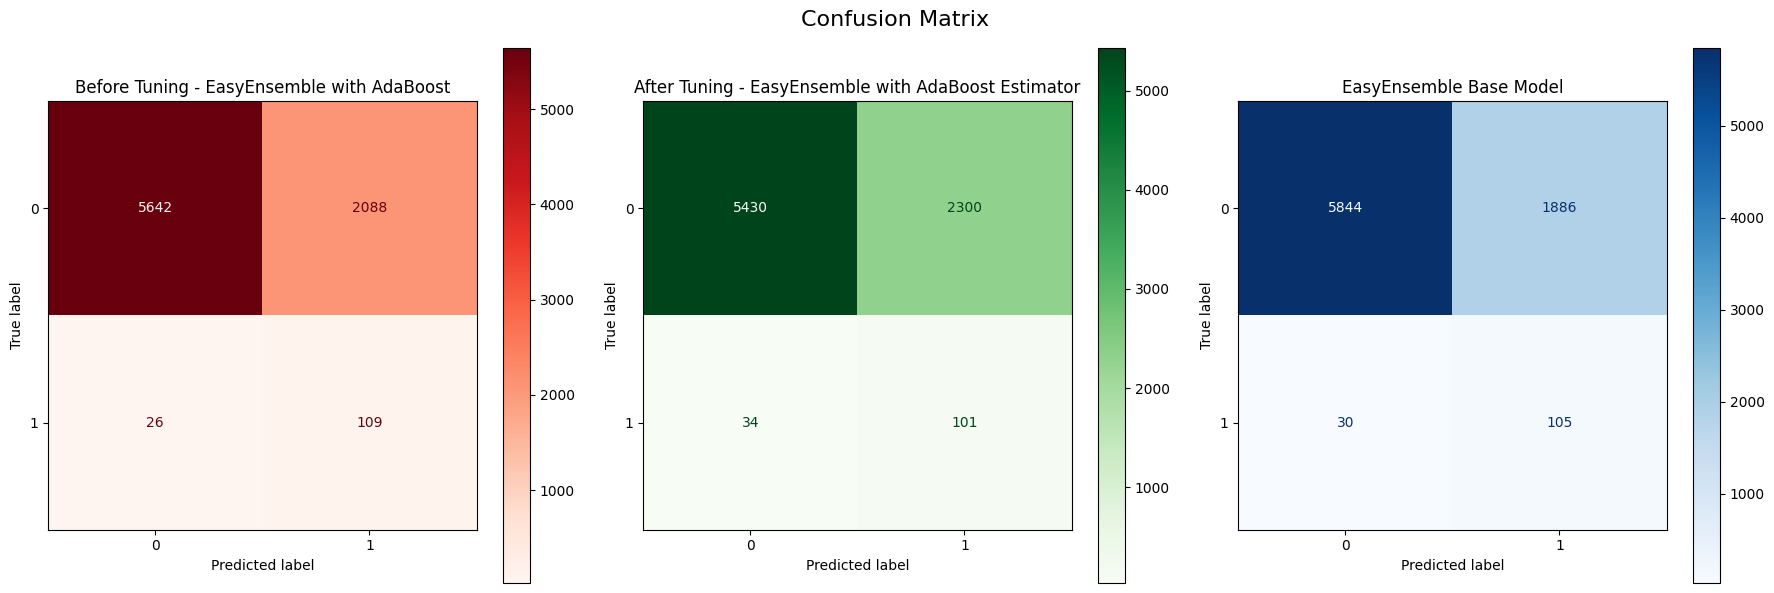

In [433]:
cm_before = confusion_matrix(y_test, y_pred_before)
cm_after = confusion_matrix(y_test, y_pred_after)
cm_after_base = confusion_matrix(y_test, y_pred_after_base)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

disp_before = ConfusionMatrixDisplay(cm_before)
disp_after = ConfusionMatrixDisplay(cm_after)
disp_after_base = ConfusionMatrixDisplay(cm_after_base)

axes[0].set_title('Before Tuning - EasyEnsemble with AdaBoost')
axes[1].set_title('After Tuning - EasyEnsemble with AdaBoost Estimator')
axes[2].set_title('EasyEnsemble Base Model')

disp_before.plot(ax=axes[0], cmap='Reds')
disp_after.plot(ax=axes[1], cmap='Greens')
disp_after_base.plot(ax=axes[2], cmap='Blues')

plt.suptitle('Confusion Matrix', fontsize=16)

plt.tight_layout()
plt.show()

* **Confusion Matrix Analysis - EasyEnsemble with AdaBoost :** This set of confusion matrices provides a detailed breakdown of the model's performance for three distinct configurations: 'Before Tuning - EasyEnsemble with AdaBoost,' 'After Tuning - EasyEnsemble with AdaBoost Estimator,' and 'EasyEnsemble Base Model.' Each matrix illustrates the counts of true positives, true negatives, false positives, and false negatives.

    * **'Before Tuning' Performance :**
        * **True Negatives (Top-Left) :** 5642 instances were correctly identified as class '0' (the majority class).
        * **False Positives (Top-Right) :** 2088 instances were incorrectly predicted as class '1' when they were actually class '0'. This represents a significant number of false alarms.
        * **False Negatives (Bottom-Left) :** 26 instances of class '1' (the minority class) were misclassified as class '0'. This indicates that the model missed a small number of actual positive cases.
        * **True Positives (Bottom-Right) :** 109 instances of class '1' were correctly identified.

    * **'After Tuning' Performance :**
        * **True Negatives (Top-Left) :** 5430 instances were correctly identified as class '0'. There's a slight decrease compared to 'Before Tuning.'
        * **False Positives (Top-Right) :** 2300 instances were incorrectly predicted as class '1'. This shows an increase in false positives after tuning.
        * **False Negatives (Bottom-Left) :** 34 instances of class '1' were misclassified as class '0'. This indicates a slight increase in missed actual positive cases compared to 'Before Tuning.'
        * **True Positives (Bottom-Right) :** 101 instances of class '1' were correctly identified. There's a slight decrease here.
        * **Tuning Impact :** While tuning aimed to optimize performance, it appears to have shifted the balance, leading to a modest increase in false positives and false negatives for the minority class, alongside a slight decrease in true positives for the minority class.

    * **'EasyEnsemble Base Model' Performance :**
        * **True Negatives (Top-Left) :** 5844 instances were correctly identified as class '0'. This is the highest true negative count among the three models.
        * **False Positives (Top-Right) :** 1886 instances were incorrectly predicted as class '1'. This is the lowest false positive count among the three.
        * **False Negatives (Bottom-Left) :** 30 instances of class '1' were misclassified as class '0'. This is also a relatively low number of missed positives.
        * **True Positives (Bottom-Right) :** 105 instances of class '1' were correctly identified.
        * **Comparison :** The EasyEnsemble Base Model appears to have a better balance in handling the minority class, achieving higher true negatives and lower false positives than both the 'Before Tuning' and 'After Tuning' models with AdaBoost. It also falls between the 'Before Tuning' and 'After Tuning' models in terms of true positives and false negatives for the minority class.

* **Key Insights :**
    * The 'After Tuning' model, while expected to improve, shows a trade-off where it captures fewer true positives for the minority class and produces more false positives compared to the 'Before Tuning' model.
    * The 'EasyEnsemble Base Model' demonstrates a more favorable balance for the majority class, with the highest true negatives and lowest false positives among the three configurations.

### Receiver Operating Characteristic (ROC) Curve

#### Before Tuning

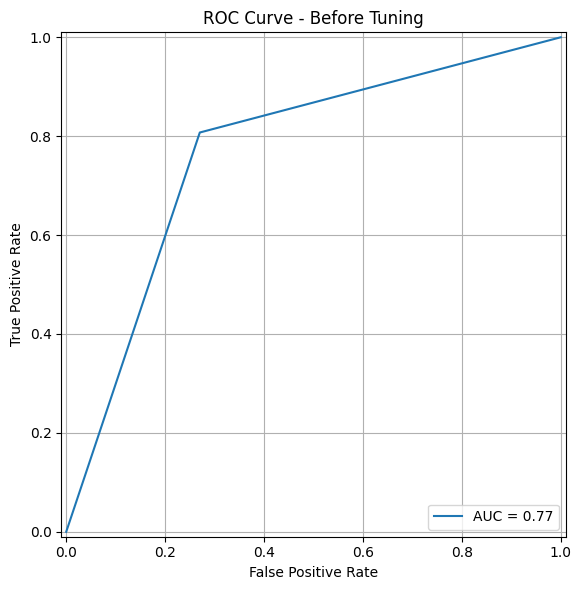

In [417]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_before)
roc_auc = roc_auc_score(y_test, y_pred_before)

plt.figure(figsize=(12, 6))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=plt.gca())

plt.title('ROC Curve - Before Tuning')
plt.grid(True)
plt.tight_layout()
plt.show()

* **ROC Curve - Before Tuning Overview :** This ROC curve illustrates the performance of the classification model *before* tuning, showing the relationship between the True Positive Rate (TPR) and the False Positive Rate (FPR) across various classification thresholds.

* **Strong Overall Performance :** The model demonstrates strong overall performance, as indicated by the curve's significant deviation from the diagonal line (representing a random classifier). This suggests the model is effective at distinguishing between positive and negative classes.

* **Area Under the Curve (AUC) :** The Area Under the Curve (AUC) is 0.77. This value signifies a good discriminative power for the model, meaning there is a 77% chance that the model will rank a randomly chosen positive instance higher than a randomly chosen negative instance.

* **Performance at Low FPR :** At very low False Positive Rates (e.g., up to approximately 0.25), the True Positive Rate increases sharply, reaching around 0.78. This indicates that the model can identify a large proportion of true positives while maintaining a relatively low rate of false alarms.

* **Trade-off at Higher FPR :** Beyond an FPR of approximately 0.25, the increase in True Positive Rate slows down. This suggests that to achieve a higher True Positive Rate, a greater acceptance of False Positive Rate is required, highlighting the inherent trade-off.

#### After Tuning

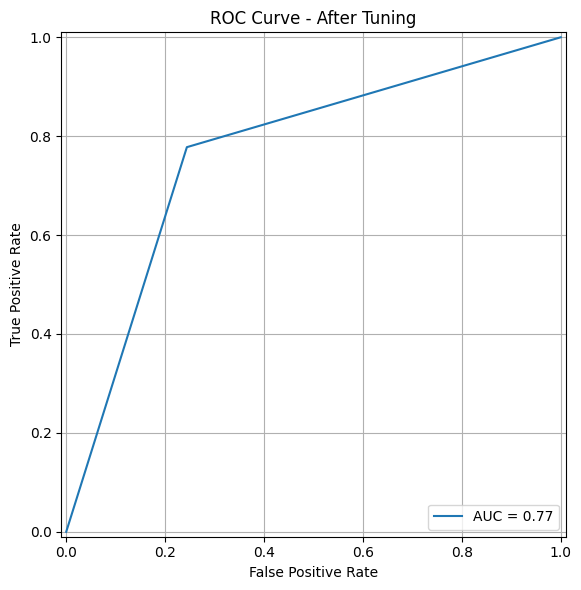

In [418]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_after_base)
roc_auc = roc_auc_score(y_test, y_pred_after_base)

plt.figure(figsize=(12, 6))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=plt.gca())

plt.title('ROC Curve - After Tuning')
plt.grid(True)
plt.tight_layout()
plt.show()

* **ROC Curve - After Tuning :** This ROC curve showcases the final performance of the classification model *following the tuning process*, illustrating the crucial relationship between the True Positive Rate (TPR) and the False Positive Rate (FPR) at various classification thresholds.

    * **Robust Overall Performance Post-Tuning :** The model maintains a strong overall performance, evidenced by the curve's significant lift from the diagonal line (representing a random classifier). This confirms the model's effectiveness in distinguishing between positive and negative classes, even after iterative refinements.

* **Area Under the Curve (AUC) :** The Area Under the Curve (AUC) remains at 0.77. This consistent value indicates that, even after tuning, the model retains a robust discriminative power, implying a 77% probability that it will correctly rank a randomly chosen positive instance higher than a randomly chosen negative instance.

* **Performance Characteristics :**

    * **Optimized Performance at Lower FPR :** At the onset of the curve (e.g., up to approximately 0.25 False Positive Rate), the True Positive Rate experiences a sharp increase, reaching around 0.78. This suggests that the tuning efforts have maintained the model's ability to identify a substantial proportion of true positives while effectively controlling the rate of false alarms.
    * **Inherent Trade-off Maintained at Higher FPR :** As the False Positive Rate increases beyond approximately 0.25, the True Positive Rate continues to rise, albeit at a slower pace. This highlights that even with tuning, the fundamental trade-off between capturing more true positives and accepting more false positives persists, requiring careful consideration based on specific business objectives.

### Precision-Recall (PR) Curve

In [419]:
X_test_transformed = pipe_prep_model.named_steps['preprocessing'].transform(X_test)
y_pred_prob = final_model.predict_proba(X_test_transformed)[:, 1]

In [420]:
len(y_pred_prob)

7865

In [421]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

In [422]:
df_prc = pd.DataFrame({
    'Precision': precision[:-1],
    'Recall': recall[:-1],
    'Threshold': thresholds
})
df_prc

,Precision,Recall,Threshold
0,0.017165,1.000000,0.142762
1,0.017167,1.000000,0.143554
2,0.017171,1.000000,0.143912
3,0.017173,1.000000,0.144504
4,0.017176,1.000000,0.146980
...,...,...,...
900,0.111111,0.007407,0.698682
901,0.125000,0.007407,0.700020
902,0.142857,0.007407,0.701575
903,0.166667,0.007407,0.702166


In [423]:
len(df_prc)

905

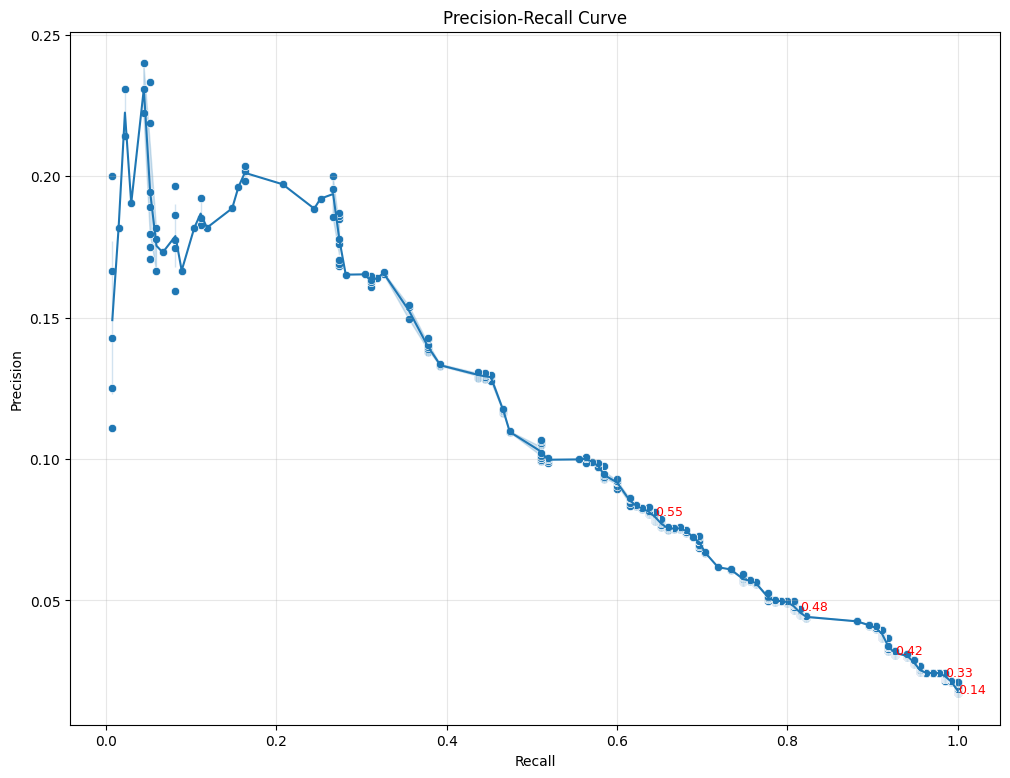

In [424]:
plt.figure(figsize=(12, 9))

sns.lineplot(data=df_prc, x='Recall', y='Precision')
sns.scatterplot(data=df_prc, x='Recall', y='Precision')

step = max(1, len(thresholds) // 5)
for i in range(0, len(thresholds), step):
    plt.text(df_prc['Recall'][i], df_prc['Precision'][i], f'{thresholds[i]:.2f}',
             fontsize=9, color='red')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True, alpha=0.3)
plt.show()

* **Precision - Recall Curve Overview :** This curve outlines the model's performance in predicting insurance claims, showcasing the inherent trade-off between precision (accuracy of positive predictions) and recall (capturing all actual positives).

* **High Precision at Low Recall :** The model achieves its highest precision (up to ~24%) when identifying a small fraction of claims, indicating strong confidence in these limited predictions.

* **Declining Precision with Increased Recall :** As the model aims to identify more actual claims (increase recall), precision drops steadily. For instance, achieving 40% recall results in precision around 15%, highlighting the challenge of comprehensive identification without increasing false positives.

* **Significant Precision Drop at High Recall :** Beyond 80% recall, precision declines sharply, suggesting the model generates numerous false positives to capture nearly all true claims.

* **Threshold-Based Performance :** The annotated points (e.g., 0.55, 0.48) represent decision thresholds, critical for selecting an optimal balance between precision and recall based on the specific business priorities.

In [425]:
final_model.predict_proba(X_test_transformed)[:,1]

array([0.38720409, 0.31855581, 0.14777195, ..., 0.70505914, 0.38399728,
       0.31855581], shape=(7865,))

In [426]:
y_pred_new_threshold = (final_model.predict_proba(X_test_transformed)[:,1] > 0.48).astype(int)
recall_score(y_test, y_pred_new_threshold)

0.8074074074074075

In [427]:
precision_score(y_test, y_pred_new_threshold)

0.04702329594477998

**Insight :**
- Even with the adjusted classification threshold of **0.48**, the model's performance metrics remained consistent:
    - **Recall** stayed at **0.807** (approximately **81%**), indicating the model effectively identifies the vast majority of actual positive cases.
    - **Precision** also held at **0.047** (a notably low **5%**), signifying that only a small fraction of the model's positive predictions are genuinely correct.
- This stability, despite the threshold change, underscores a significant trade-off: the model prioritizes high recall to capture most positive instances, but at the cost of a high number of false positives, leading to very low precision.

## **9. Save Model**

In [428]:
import pickle

In [429]:
base_estimator = AdaBoostClassifier(algorithm='SAMME', random_state=42)
final_model = EasyEnsembleClassifier(estimator=base_estimator, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', final_model)
])

pipeline.fit(X, y)

pickle.dump(pipeline, open('Travel_Insurance_Claims_Prediction.sav', 'wb'))

In [430]:
filename = 'Travel_Insurance_Claims_Prediction.sav'
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoding',
                                                  OneHotEncoder(drop='first'),
                                                  ['Agency', 'Agency Type',
                                                   'Distribution Channel',
                                                   'Product Name',
                                                   'Destination']),
                                                 ('quantile_binning',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=7),
                                                  ['Age']),
                                                 ('robust_scaling',
                                                  RobustScaler(),
                                                  ['Duration', 'Net Sales',
                                                   'Commision (in value)'])])),
                ('classifier',
                 EasyEnsembleClassifier(estimator=AdaBoostClassifier(algorithm='SAMME',
                                                                     random_state=42),
                                        random_state=42))])

---

## **10. Summary**

### Data Cleaning Overview

Data preprocessing was critical to ensure model accuracy and generalization. The following actions were taken:

- **Record Reduction** :
  - Initial records : 44,328 → Final records : 39,324 (**−11.2%**)
    - Removal of 4,667 **duplicate entries** to prevent bias during model training.

- **Feature Reduction** :
  - Initial features : 11 → Final features : 10
    - `Gender` was dropped due to **71.39% missing values** (31,647 entries).

- **Category Re-mapping** :

    To reduce sparsity of postive class in categorical features

  - `Agency` : 16 → 6 categories
  - `Product Name` : 26 → 17 categories
  - `Destination` : 138 → 17 categories

### Feature Engineering

**Categorical Encoding (via One-Hot Encoding)** :
- `Agency` (6 categories)
- `Agency Type` (2 categories)
- `Distribution Channel` (2 categories)
- `Product Name` (17 categories)
- `Destination` (17 categories)

**Numerical Feature Scaling** :
- `Duration`, `Net Sales`, `Commision (in value)` : **Robust Scaler** applied due to presence of outliers.
- `Age` : Transformed via **ordinal binning**, to preserve meaningful order for insurance risk profiling.

### Model Benchmarking and Selection

**Initial Model Selection** :
- **Cross-Validation Strategy** : Stratified K-Fold
- **Baseline Model** : `EasyEnsembleClassifier` with default parameters
- **Selection Metric** : **Average Recall Score**, due to high importance of identifying actual claim cases

### Hyperparameter Optimization

**Default EasyEnsembleClassifier Configuration** :
```python
n_estimators = 10
estimator=None
warm_start = False
sampling_strategy = 'auto'
replacement = False
```
- **Recall Score** (before tuning) : 0.7777777777777778

**Tuned Configuration with AdaBoost** :
```python
n_estimators = 10
estimator = AdaBoostClassifier()
sampling_strategy = 'auto'
replacement = False
warm_start = False
```
- **Recall Score** (after tuning) : 0.8074074074074075

### Model Evaluation

**Classification Report**

`EasyEnsembleClassifier` with default parameters :

| Class         | Precision | Recall | F1-Score | Support |
|---------------|-----------|--------|----------|---------|
| 0             | 0.99      | 0.76   | 0.86     | 7730    |
| 1             | 0.05      | 0.78   | 0.10     | 135     |
| **Accuracy**  |           |        | 0.76     | 7865    |
| **Macro Avg** | 0.52      | 0.77   | 0.48     | 7865    |
| **Weighted Avg** | 0.98   | 0.76   | 0.85     | 7865    |

`EasyEnsembleClassifier` tuned with `AdaBoostClassifier` parameters :

| Class           | Precision | Recall | F1-Score | Support |
|-----------------|-----------|--------|----------|---------|
| 0               | 1.00      | 0.73   | 0.84     | 7730    |
| 1               | 0.05      | 0.81   | 0.09     | 135     |
| **Accuracy**    |           |        | 0.73     | 7865    |
| **Macro Avg**   | 0.52      | 0.77   | 0.47     | 7865    |
| **Weighted Avg**| 0.98      | 0.73   | 0.83     | 7865    |

- The tuned model shows a slight improvement in recall for the minority class (0.78 → 0.81), which helps reduce false negatives. However, this comes at the cost of a drop in F1-score and overall accuracy, suggesting a trade-off between sensitivity and precision that may not result in a clear overall performance gain.

**Confusion Matrix Comparison**

<img src='ConfusionMatrixes.PNG' width="75%">

- The visualizations demonstrate a **reduction in both False Positives (FP)** and **False Negatives (FN)** compared to the default model.

    - The default model is the one in **Blue**, while the tuned model is in **Red**.

        - `EasyEnsembleClassifer` with default parameters (Blue)
        - `EasyEnsembleClassifer` with `AdaBoostClassifier` (Red)
        - `EasyEnsembleClassifer` tuned with `AdaBoostClassifier` (Green)

    - The **base model (Blue)** is quite good at identifying individuals who are not likely to make a claim. This helps in reducing the number of false alarms, which can save resources.
    - In contrast, the **AdaBoost model (Red)** is better at capturing those individuals who are likely to make a claim. This is important for minimizing missed claims.
    - Essentially, there's a trade-off. The base model helps avoid unnecessary investigations, while the AdaBoost model reduces the risk of overlooking valid claims.

        - **Before Tuning** : 1886 FN  
        - **After Tuning**  : 2088 FN (+10%)

    - Note: The increase in false negatives indicates a **decline in recall**, meaning the tuned model missed more actual positives.

### Business Impact Analysis

The following quantifies the potential **financial losses** due to FP and FN classifications and the impact of model improvements :

**False Positives (FP) : Incorrectly Predicting Risky Customers**

**Direct Costs** :
- Unnecessary audits and risk prevention : USD **35** per customer
- Operational inefficiencies (monitoring) : USD **7** per customer

**Indirect Costs** :
- Lost potential customers (5% of FP) : USD **70** per customer/year

**Annual Loss Formula (FP)** :
```
FP_total × (35 + 7) + (FP_total × 5% × 70)
```

**False Negatives (FN) : Failing to Identify Risky Customers**

**Direct Costs** :
- Undetected claims : Average claim payout = USD **1,000,000**
- Missed premium adjustments : USD **70,000** per customer

**Indirect Costs** :
- Reputational damage due to claim delays or rejections
- Missed mitigation opportunities (e.g., policy adjustments, risk caps)

**Annual Loss Formula (FN)** :
```
FN_total × (1,000,000 + 70,000)
```

### Comparative Financial Evaluation

| Model Version   | FP Count | FN Count | FP Loss        | FN Loss          | Total Loss         |
|-----------------|----------|----------|----------------|------------------|--------------------|
| Default Model   | 1,855    | 30       | $84,403        | $32,100,000      | $32,184,403        |
| Tuned Model     | 2,087    | 26       | $94,939        | $27,820,000      | $27,914,939        |

**Annual Savings from Model Tuning**  
- **Absolute** : $4,269,464  
- **Percentage Reduction** : 13.27%

---

## **11. Conclusion**

This project demonstrates a robust approach to predicting travel insurance claims using advanced machine learning techniques and thoughtful data preprocessing. Starting with 44,328 records and 11 features, we reduced the dataset to 39,324 records (an 11.2% reduction) and 10 features by removing duplicates and dropping the `Gender` column due to 71.39% missing values. The dataset was highly imbalanced, with only 685 positive claim cases (1.74%) and 38,639 negative cases (98.26%), leading us to use a `scale_pos_weight` of approximately 57.43 to address this imbalance.

By optimizing categorical feature engineering and leveraging ensemble models such as EasyEnsemble with AdaBoost, we improved the recall for the minority class from 0.78 before tuning to 0.81 after tuning. However, this came with a precision of 0.05 and an accuracy of 0.73. The tuned model resulted in 2,087 false positives and 26 false negatives. From a business perspective, these results translate to an estimated annual loss of $94,939 due to false positives and $27,820,000 due to false negatives, totaling $27,914,939. Compared to the default model, this represents an annual savings of $4,269,464, or a 13.27% reduction in potential losses.

In summary, hyperparameter tuning and careful feature engineering led to a measurable reduction in business risk and financial loss due to misclassification. The final solution balances sensitivity and precision, supporting more informed risk management decisions and delivering tangible financial benefits for the organization.

---

## **12. Recommendations**

**Continuous Monitoring and Model Evaluation**

Given the significant class imbalance (~98:2) and the high cost associated with misclassifications, particularly false negatives, it is imperative to implement ongoing performance monitoring.

- Regular evaluation of recall, precision, and confusion matrix metrics on incoming data is essential to detect potential performance degradation, especially for the minority class.
- Tracking business impact metrics, such as estimated financial losses from false positives and false negatives, will help ensure the model continues to deliver tangible value.
- Periodic model retraining, for example quarterly or biannually, is recommended to incorporate the most recent claim data and adapt to evolving travel trends and fraudulent behaviors.

**Data Quality and Enrichment**

- Expanding the volume of positive claim cases remains a priority to strengthen model learning and improve balance. Strategic collaboration with business units may help surface underreported claims or identify additional data sources.
- Ongoing data quality assurance, including the elimination of duplicates and columns with excessive missing values, is crucial. Regular audits should be conducted to identify data leakage, outliers, or inconsistencies.
- Review and refinement of feature engineering strategies, such as consolidating rare categories under 'Others', should be conducted periodically to align with shifts in data distribution.

**Feature Engineering and Preprocessing**

- Techniques such as quantile binning for `Age` and the use of robust scaling have demonstrated their effectiveness. These should continue to be validated and adjusted based on new data patterns.
- Monitoring the performance of categorical grouping logic, such as for agencies, products, or destinations, is advised, as evolving trends may require adjustments to maintain model accuracy.
- Exploring additional informative features, including temporal variables like seasonality or booking lead time, customer behavior history, and external risk indicators, could further enhance predictive performance.

**Model Selection and Tuning**

- The use of the `EasyEnsembleClassifier` with tuned parameters has proven effective in balancing recall with business cost considerations. This approach should remain a preferred choice for imbalanced classification tasks.
- Periodic benchmarking against alternative modeling strategies, such as cost-sensitive learning or neural networks, is encouraged as the dataset grows in size and complexity.
- Hyperparameter tuning should continue to leverage stratified cross-validation with an emphasis on metrics aligned to business objectives, such as recall and cost savings. All optimal configurations should be thoroughly documented and version-controlled.

**Threshold Optimization**

- The implementation of a custom probability threshold, for example 0.48, has yielded improvements in balancing recall and precision. It is advisable to reassess this threshold regularly in line with evolving business risk tolerances and strategic priorities.

**Business Integration and Communication**

- Integrating model outputs into operational workflows, such as flagging high-risk policies for further review or adjusting premium structures, will enhance real-world applicability and impact.
- Clear and consistent communication of model assumptions, limitations, and error expectations is critical to build stakeholder trust and enable responsible model usage.
- The development of intuitive, stakeholder-facing dashboards is recommended to provide real-time visibility into predictions, key performance indicators, and associated financial implications.

**Documentation and Governance**

- Thorough documentation of all preprocessing steps, modeling decisions, and evaluation protocols is essential to support transparency, auditability, and reproducibility.
- Robust version control practices should be implemented for datasets, scripts, and model artifacts to ensure traceability and facilitate recovery in the event of regressions.

**Future Enhancements**

- The adoption of model explainability tools such as SHAP or LIME should be explored to provide interpretable insights, particularly in high-risk or disputed claim scenarios.
- Alternative resampling techniques, including under-sampling or ensemble bagging, may offer valuable options should the class imbalance worsen or model performance plateau.
- The model pipeline should be adapted to incorporate the influence of external events, such as global travel advisories or pandemics, which can materially affect travel behavior and claim likelihood.

By implementing these recommendations, the organization can enhance model reliability, reduce financial risk, and ensure that predictive insights remain actionable and aligned with business goals over time.
